In [714]:
%load_ext autoreload
%autoreload 2

from collections import defaultdict

import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx
import pyomo.environ as pyomo

from src.jigsawsolver import create_jigsaw, index_iter, draw_jigsaw2

import numpy as np


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [137]:
def stuple(iterable):
    return tuple(sorted(iterable))

In [226]:
def rotate_array(l, n):
    return l[n:] + l[:n]

In [2]:
rows, cols = 4, 5

In [15]:
tiles = create_jigsaw(rows, cols)

In [63]:
tile_ids = np.arange(rows * cols).reshape(rows, cols)
vertex_ids = np.arange(rows * cols * 4).reshape(rows, cols, 4)

In [68]:
vt_lookup = {v: v // 4 for v in vertex_ids.flatten()}
tv_lookup = {t: np.arange(t * 4, (t + 1) * 4) for t in tile_ids.flatten()}

In [94]:
vertex_pos = np.zeros((rows, cols, 4, 2))
for r in range(rows):
    for c in range(cols):
        vertex_pos[r, c] = [
            [c, r - 0.3],
            [c + 0.3, r],
            [c, r + 0.3],
            [c - 0.3, r],
        ]
vertex_pos = vertex_pos.reshape((-1, 2))

In [82]:
def draw_jigsaw(ax):
    cmap = mpl.cm.viridis

    for (r, c), values in index_iter(tiles, axis=(0, 1)):
        tid = tile_ids[r, c]
        ax.add_patch(mpl.patches.Rectangle((c - 0.3, r - 0.3), 0.6, 0.6, color="lightgray"))
        ax.text(c, r, tid, ha="center", va="center")

        ax.plot([c - 0.3, c + 0.3], [r - 0.3, r - 0.3], c=cmap(values[0]))
        ax.plot([c + 0.3, c + 0.3], [r - 0.3, r + 0.3], c=cmap(values[1]))
        ax.plot([c - 0.3, c + 0.3], [r + 0.3, r + 0.3], c=cmap(values[2]))
        ax.plot([c - 0.3, c - 0.3], [r - 0.3, r + 0.3], c=cmap(values[3]))

        ax.text(c, r - 0.3, tv_lookup[tid][0], ha="center", va="center", bbox=dict(facecolor="white",alpha=1))
        ax.text(c + 0.3, r, tv_lookup[tid][1], ha="center", va="center", bbox=dict(facecolor="white",alpha=1))
        ax.text(c, r + 0.3, tv_lookup[tid][2], ha="center", va="center", bbox=dict(facecolor="white",alpha=1))
        ax.text(c - 0.3, r, tv_lookup[tid][3], ha="center", va="center", bbox=dict(facecolor="white",alpha=1))

    ax.set_ylim((-1, rows))
    ax.set_xlim((-1, cols))


    ax.set_aspect(1)
    ax.invert_yaxis()

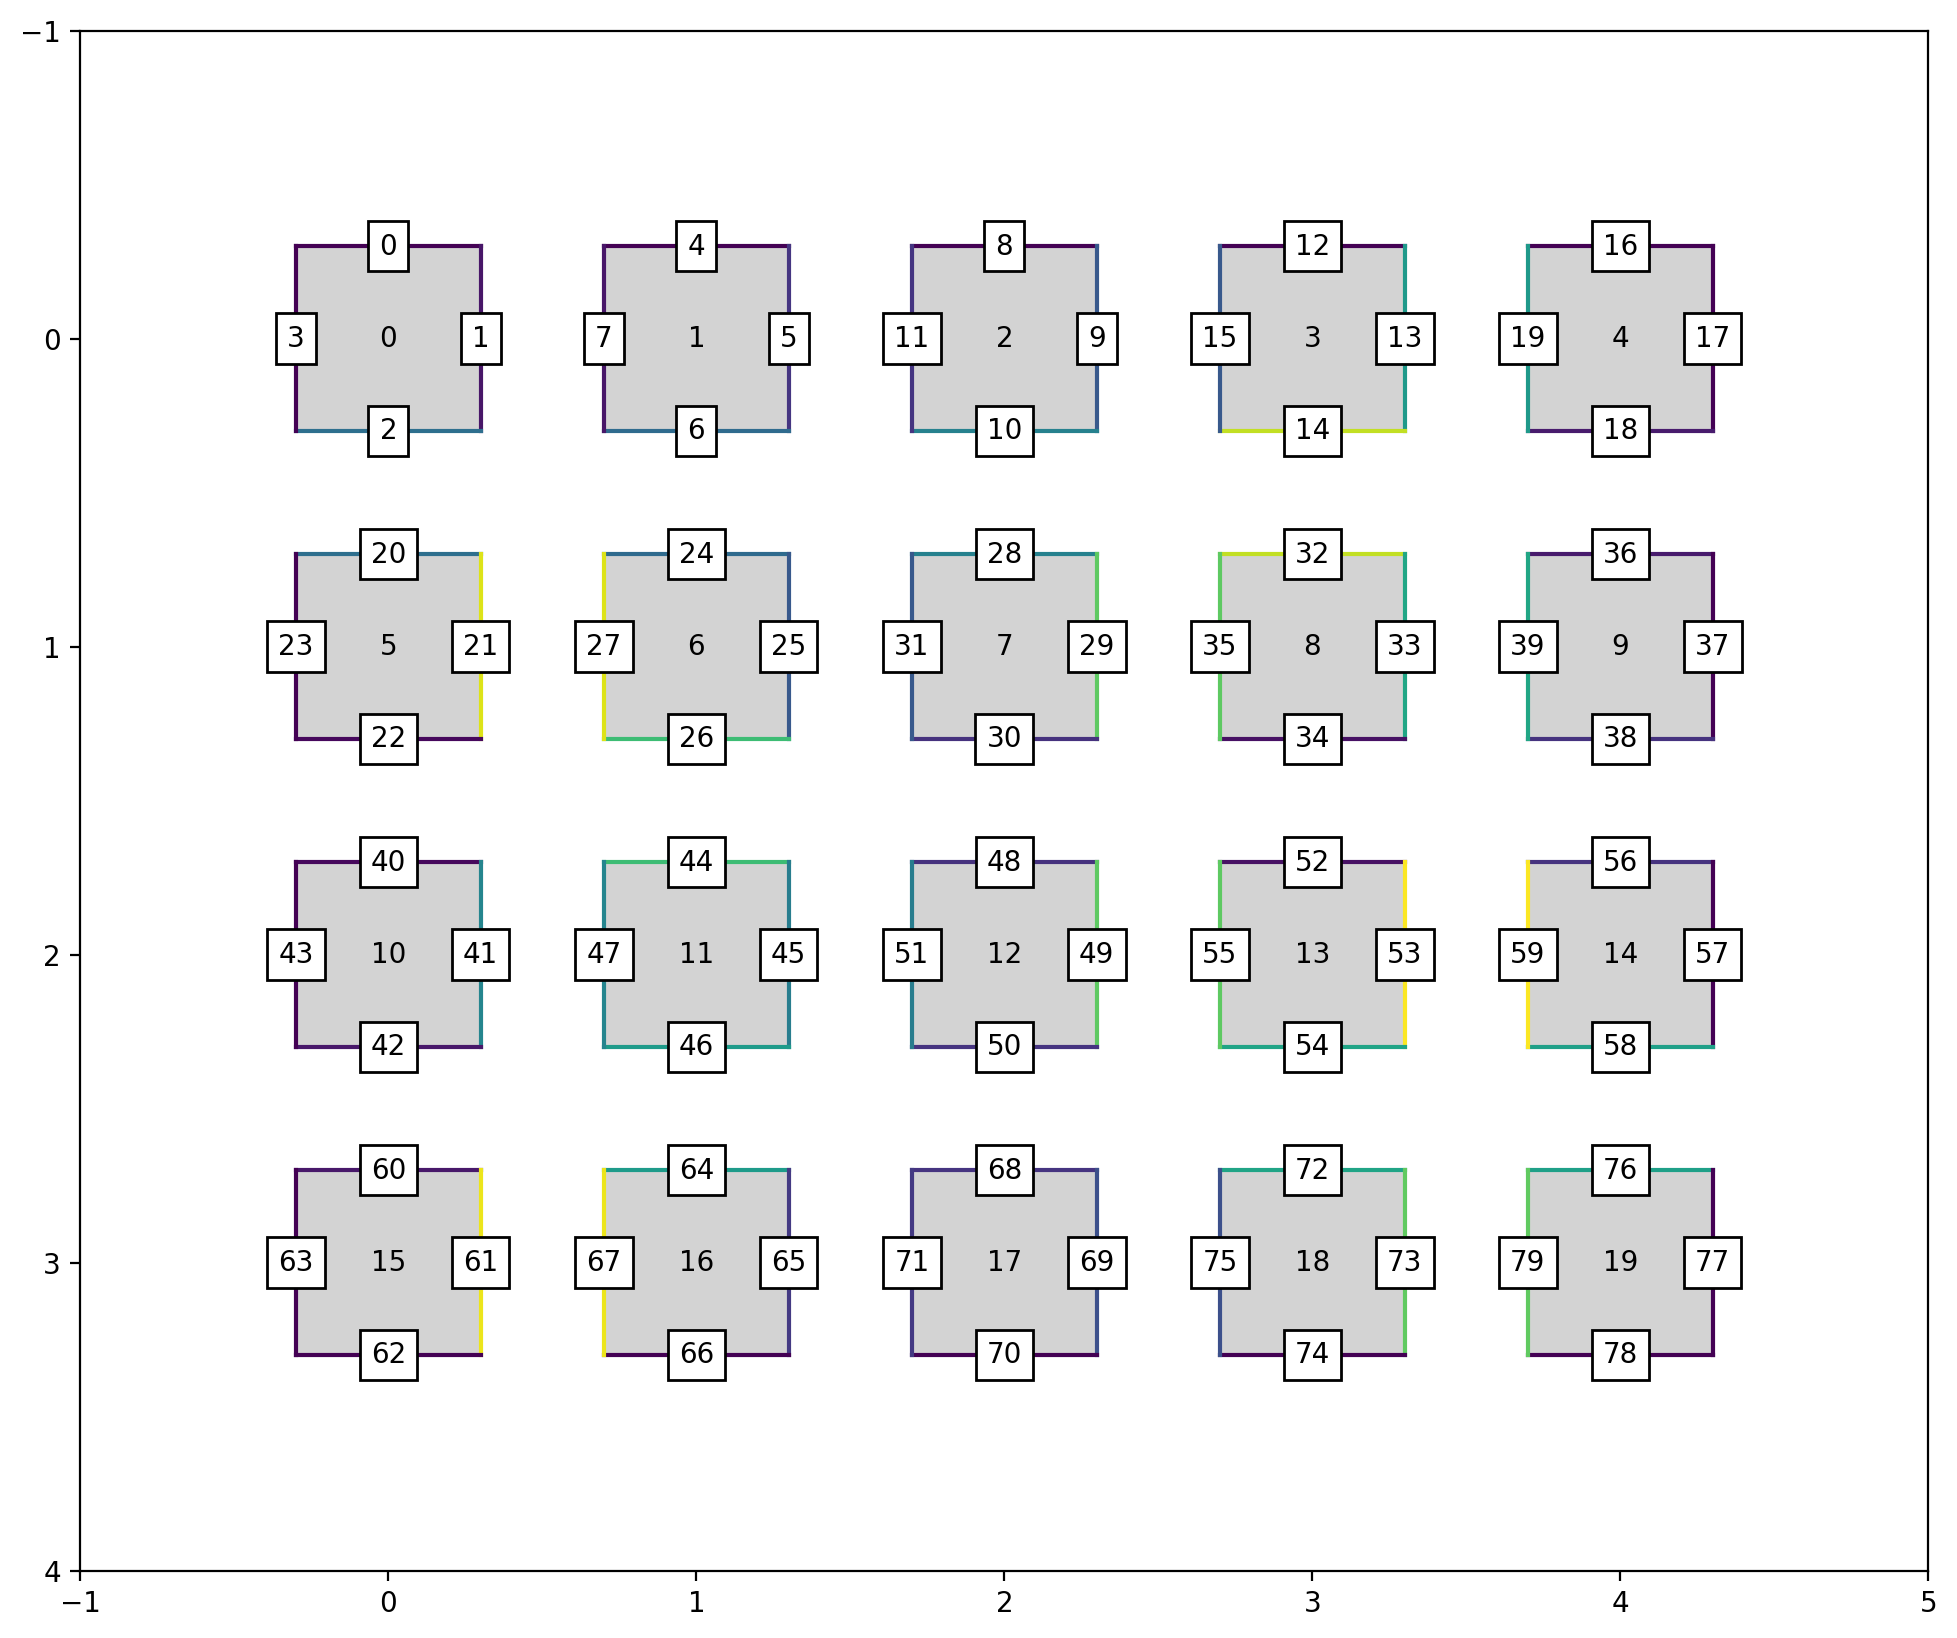

In [708]:
fig, ax = plt.subplots(dpi=200, figsize=(15, 10))
draw_jigsaw(ax)

# fig.show()

In [84]:
# Fix boundary edges

In [133]:
edges = []
for r in range(rows - 1):
    edges.append((vertex_ids[r, 0, 2], vertex_ids[r + 1, 0, 0]))
    edges.append((vertex_ids[r, -1, 2], vertex_ids[r + 1, -1, 0]))

for c in range(cols - 1):
    edges.append((vertex_ids[0, c, 1], vertex_ids[0, c + 1, 3]))
    edges.append((vertex_ids[-1, c, 1], vertex_ids[-1, c + 1, 3]))

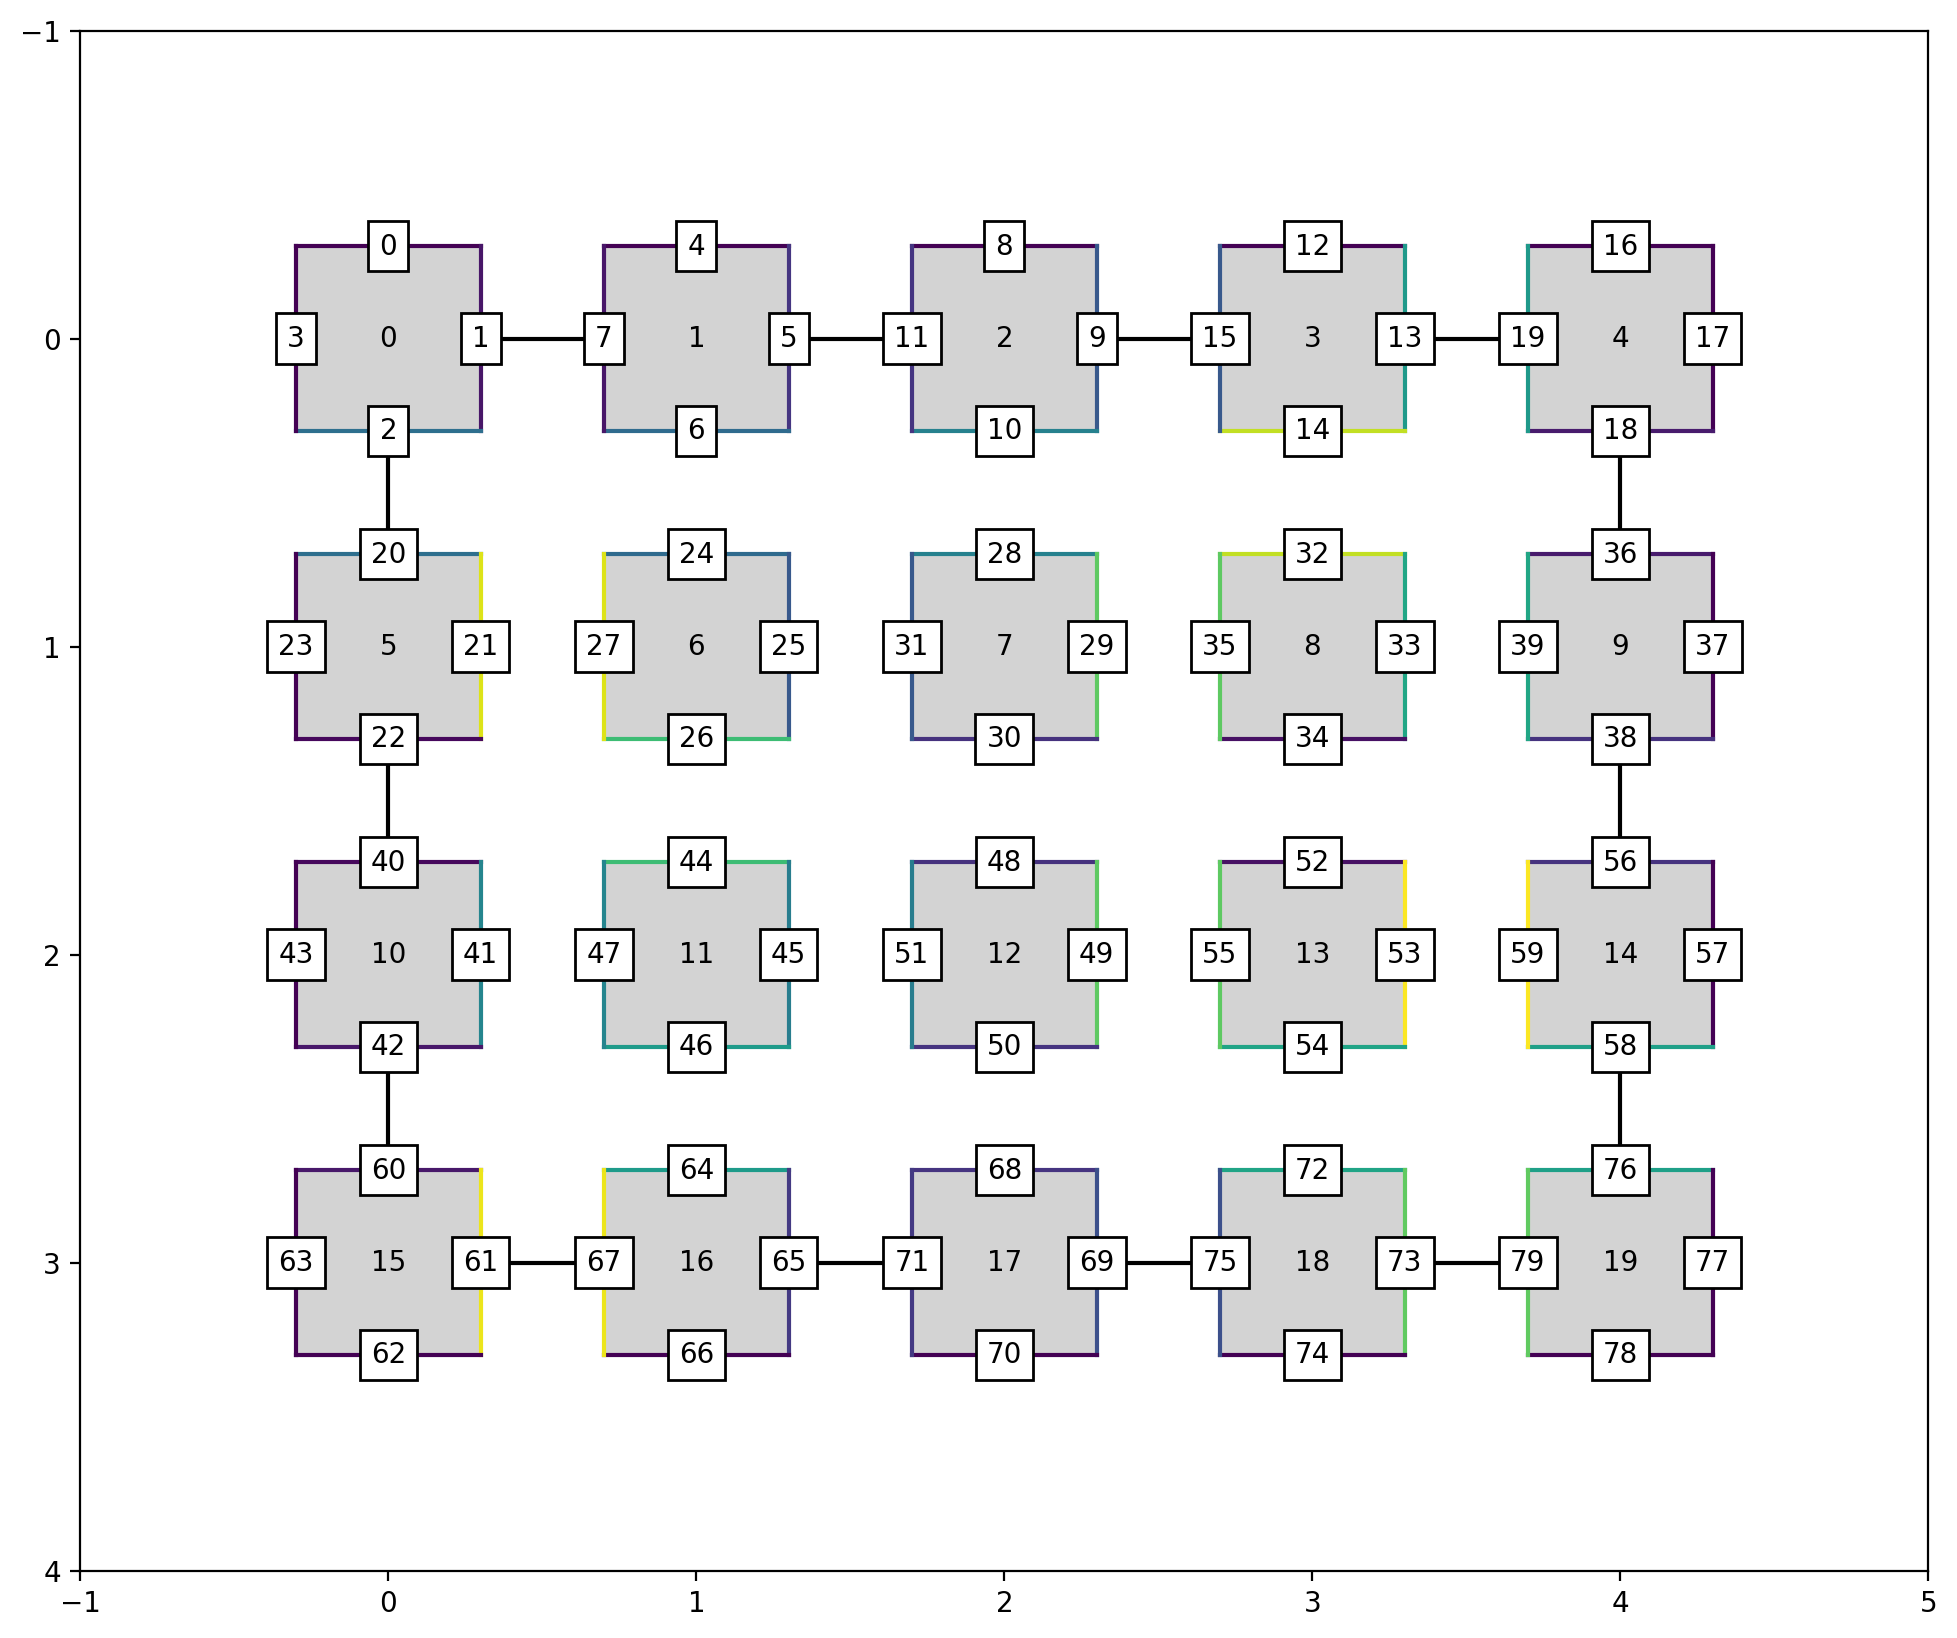

In [134]:
fig, ax = plt.subplots(dpi=200, figsize=(15, 10))
draw_jigsaw(ax)

for src, tgt in edges:
    ax.plot([vertex_pos[src][0], vertex_pos[tgt][0]], [vertex_pos[src][1], vertex_pos[tgt][1]], c="black")

In [135]:
# Find nearest neighbors for all inner edges

In [526]:
k = 2

In [527]:
relevant_vertices = np.zeros(tiles.shape, dtype=np.bool8)
relevant_vertices[1:-1, 1:-1] = True
relevant_vertices[0, 1:-1, 2] = True
relevant_vertices[-1, 1:-1, 0] = True
relevant_vertices[1:-1, 0, 1] = True
relevant_vertices[1:-1, -1, 3] = True

In [528]:
fvids = vertex_ids[relevant_vertices].flatten()
fvals = tiles[relevant_vertices].flatten()

In [529]:
for vid, val in zip(fvids, fvals):
    order = np.argsort(np.abs(fvals - val))
    knns = fvids[order][fvids[order] // 4 != vid // 4][:k]
    edges.extend([stuple([vid, neighbor_id]) for neighbor_id in knns])

In [530]:
edges = list(set(edges))

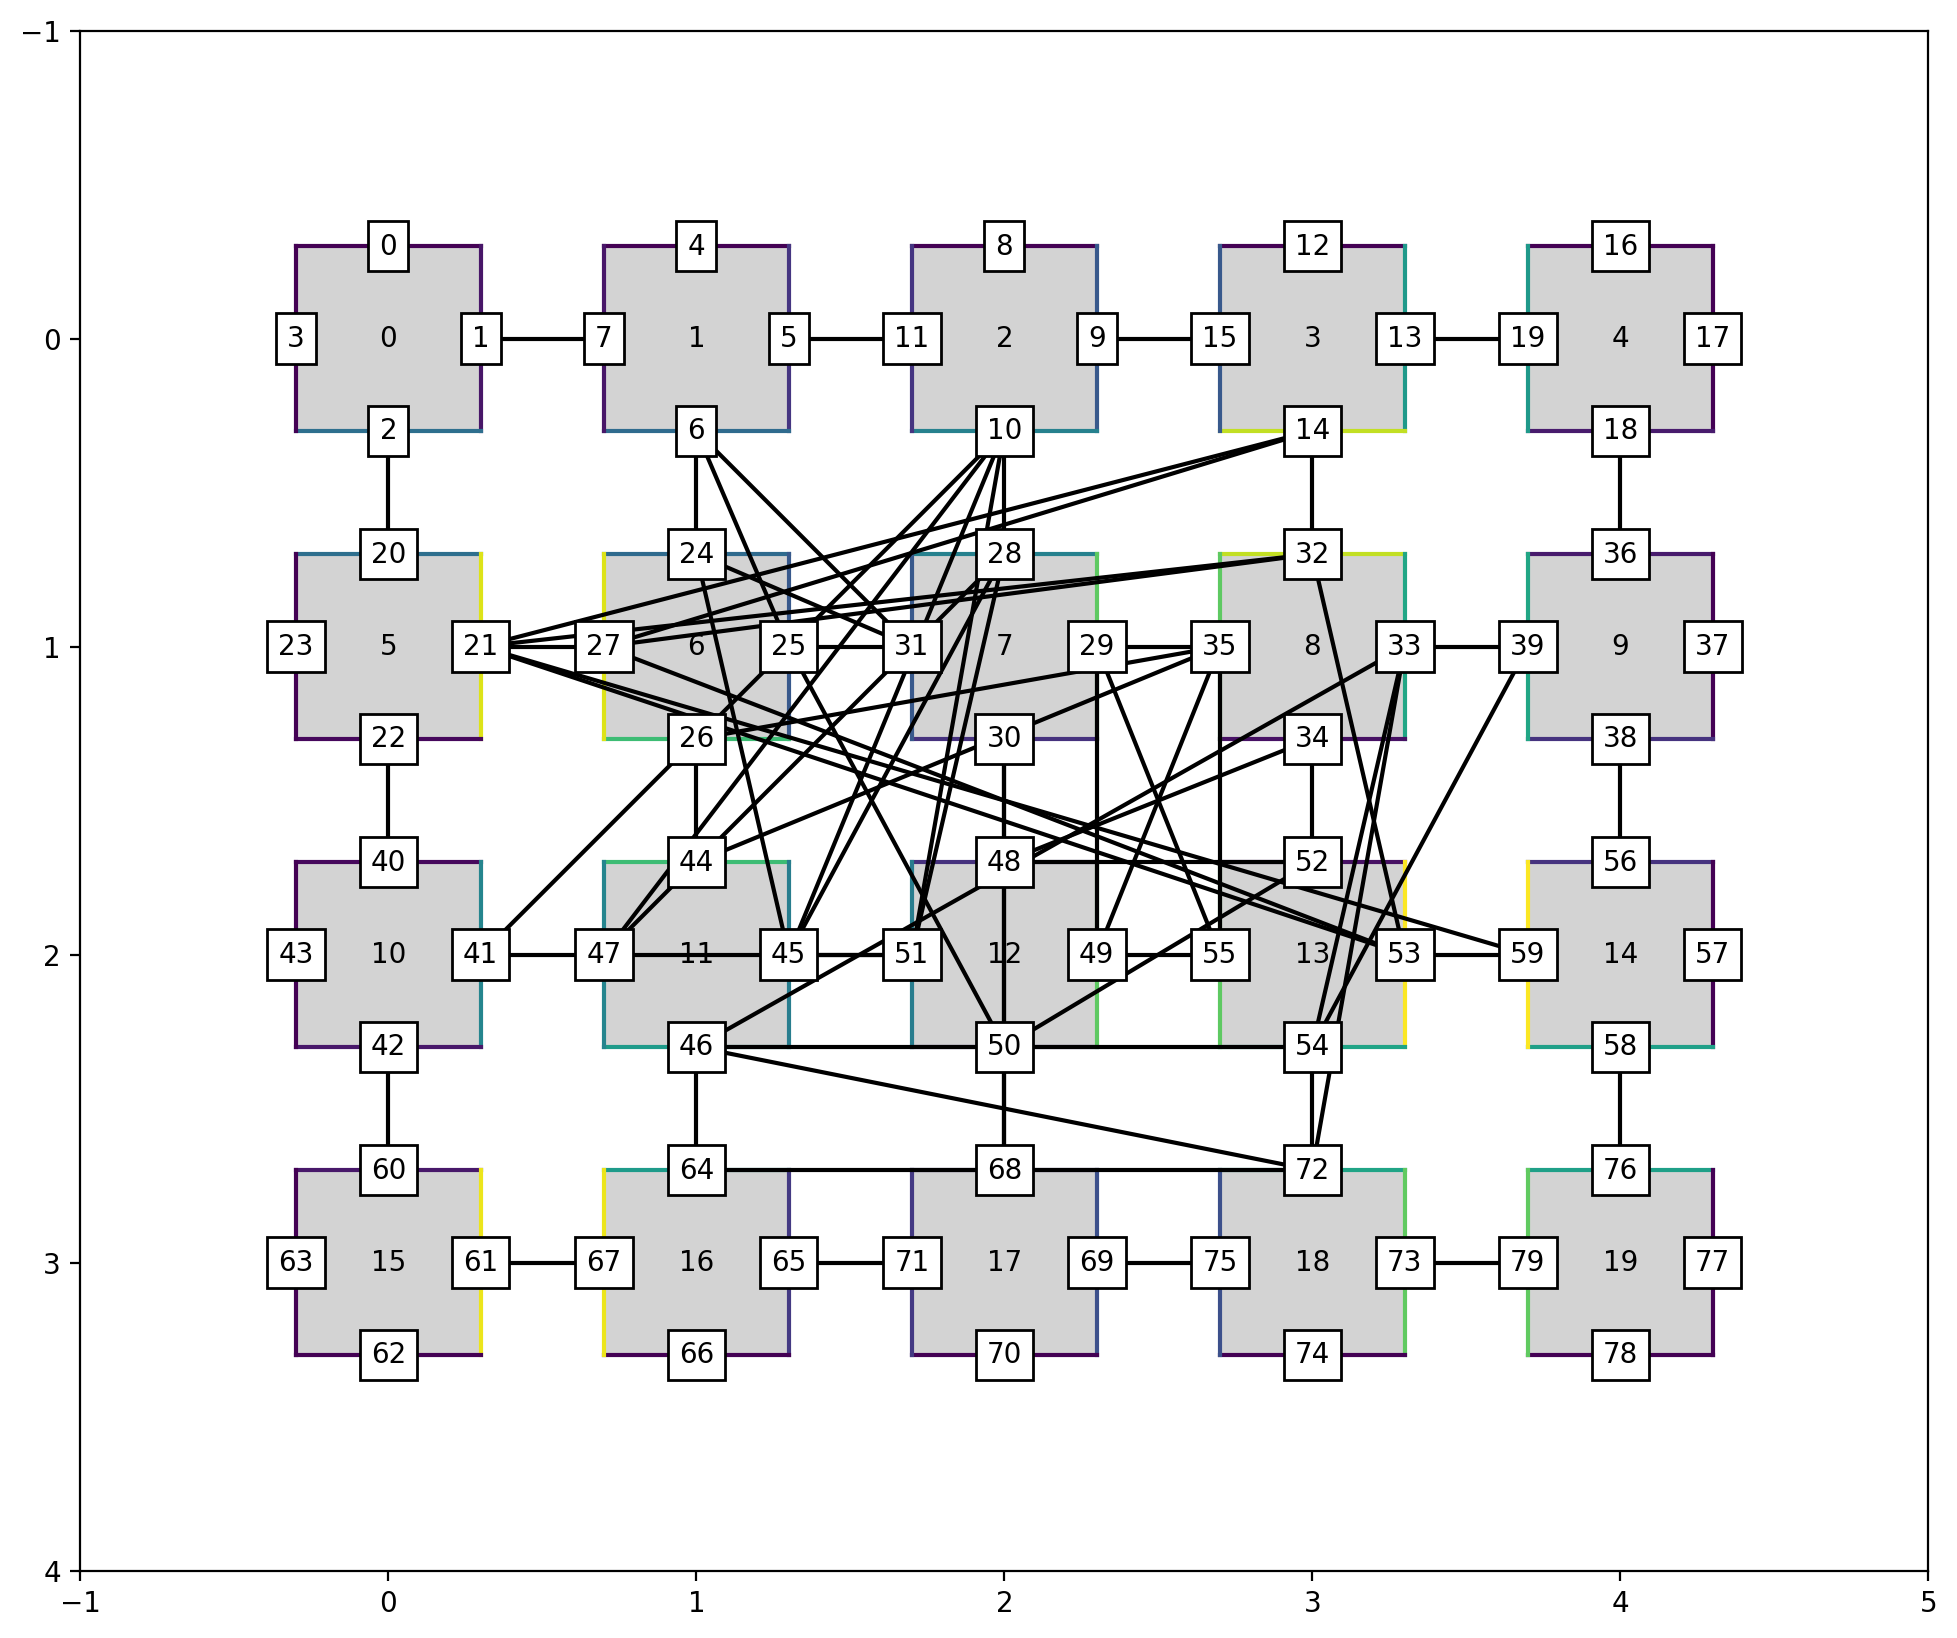

In [531]:
fig, ax = plt.subplots(dpi=200, figsize=(15, 10))
draw_jigsaw(ax)

for src, tgt in edges:
    ax.plot([vertex_pos[src][0], vertex_pos[tgt][0]], [vertex_pos[src][1], vertex_pos[tgt][1]], c="black")

In [532]:
# Find a matching within this graph

In [533]:
g = nx.Graph()
g.add_edges_from(edges)
matching = nx.max_weight_matching(g, maxcardinality=True)

matching = sorted([stuple(e) for e in matching])

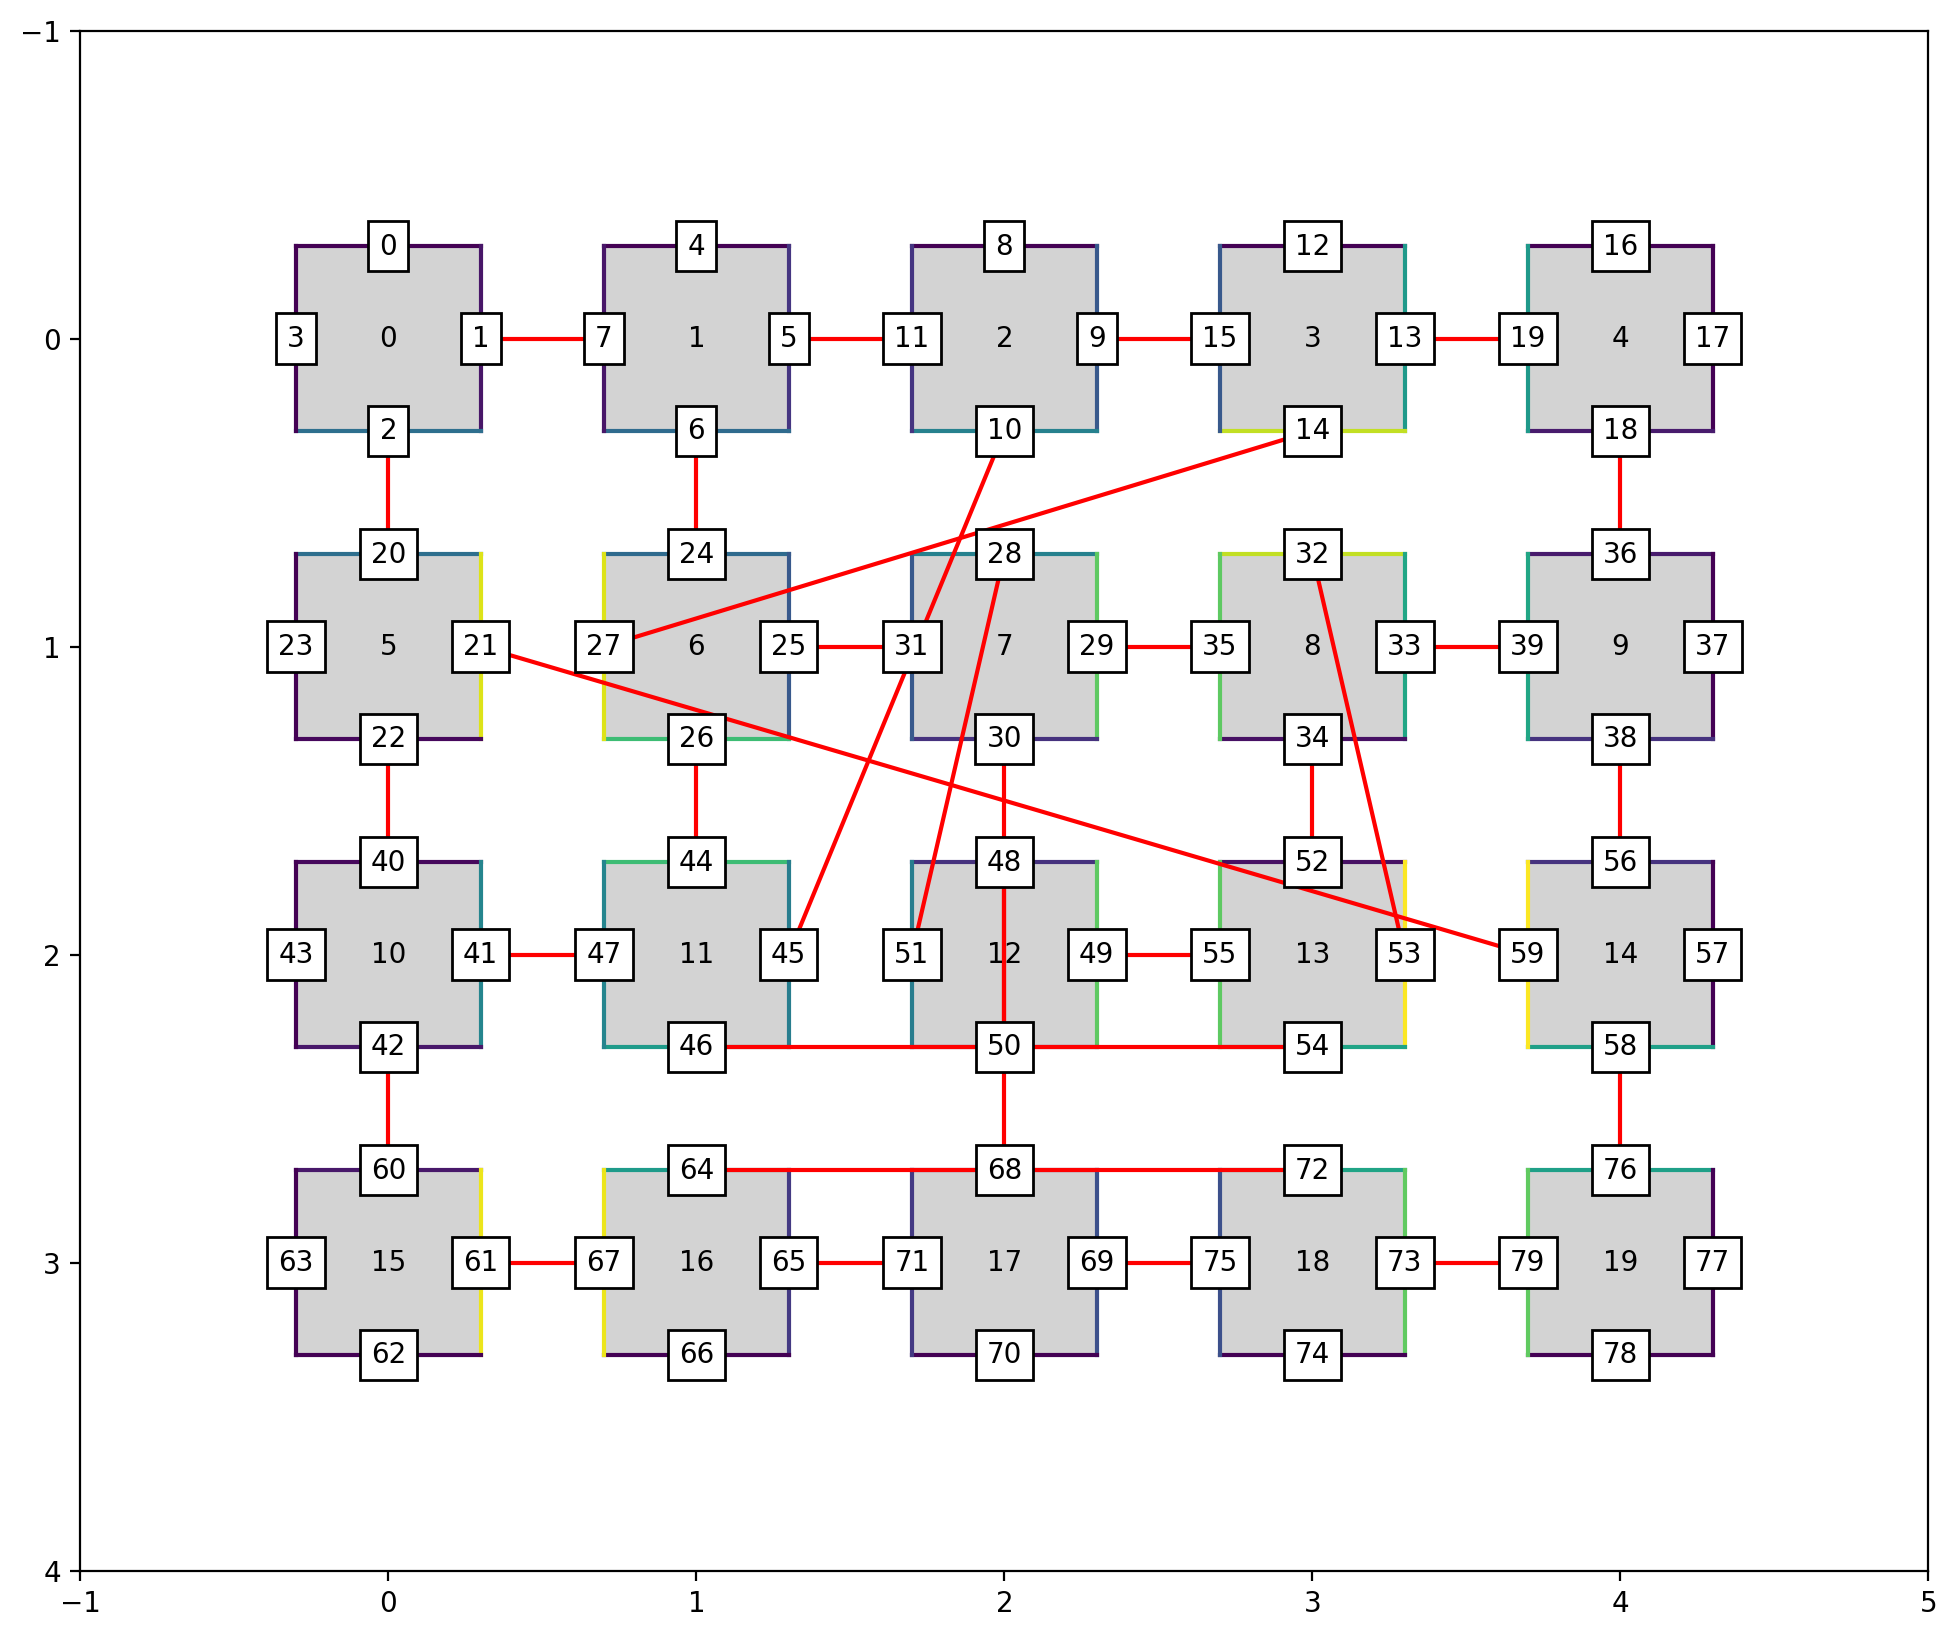

In [534]:
fig, ax = plt.subplots(dpi=200, figsize=(15, 10))
draw_jigsaw(ax)

# for src, tgt in edges:
#     ax.plot([vertex_pos[src][0], vertex_pos[tgt][0]], [vertex_pos[src][1], vertex_pos[tgt][1]], c="gray")

for src, tgt in matching:
    ax.plot([vertex_pos[src][0], vertex_pos[tgt][0]], [vertex_pos[src][1], vertex_pos[tgt][1]], c="red")

In [535]:
# Verify correctness of solution

In [536]:
# Step 1: Assign orientation of tiles and find mismatchs

In [537]:
ORIENTATIONS = ["N", "E", "S", "W"]
COUNTER_ORIENTATIONS = {
    "N": "S",
    "E": "W",
    "S": "N",
    "W": "E",
}

In [538]:
matching_lookup = {src: tgt for src, tgt in matching}
matching_lookup.update({tgt: src for src, tgt in matching})

In [541]:
stack = [matching[0][0]]
visited_tiles = set()
vertex_orientations = {
    stack[0]: ORIENTATIONS[stack[0] % 4], # Select specific start orientation for imore intuitive viualization. But any other orientation would also work.
} 
visited_edges = []
error_src, error_tgt = None, None

In [542]:
while len(stack) > 0:
    current_v = stack[0]

    tile_id = vt_lookup[current_v]
    tile_vertices = tv_lookup[tile_id]

    visited_tiles.add(tile_id)
    current_orientation = vertex_orientations[current_v]

    rotation = rotate_array(
        ORIENTATIONS,
        ORIENTATIONS.index(current_orientation) - np.where(tile_vertices == current_v)[0][0],
    )

    for src, rot in zip(tile_vertices, rotation):
        vertex_orientations[src] = rot

        tgt = matching_lookup.get(src, None)

        if tgt is not None: # Why it can be None???
            next_tile = vt_lookup[tgt]

            if next_tile in visited_tiles:
                if COUNTER_ORIENTATIONS[rot] != vertex_orientations[tgt]:
                    error_src = src
                    error_tgt = tgt
                    raise Exception(f"Orientation missmatch: Vertex {tgt} has ambiguous orientation: {COUNTER_ORIENTATIONS[rot]}, {vertex_orientations[tgt]} (Current vertex: {src})")
            else:
                stack.append(tgt)
                vertex_orientations[tgt] = COUNTER_ORIENTATIONS[rot]
                visited_edges.append(stuple((src, tgt)))
        if src in stack:
            stack.remove(src)


    # del stack[0]

Exception: Orientation missmatch: Vertex 27 has ambiguous orientation: N, W (Current vertex: 14)

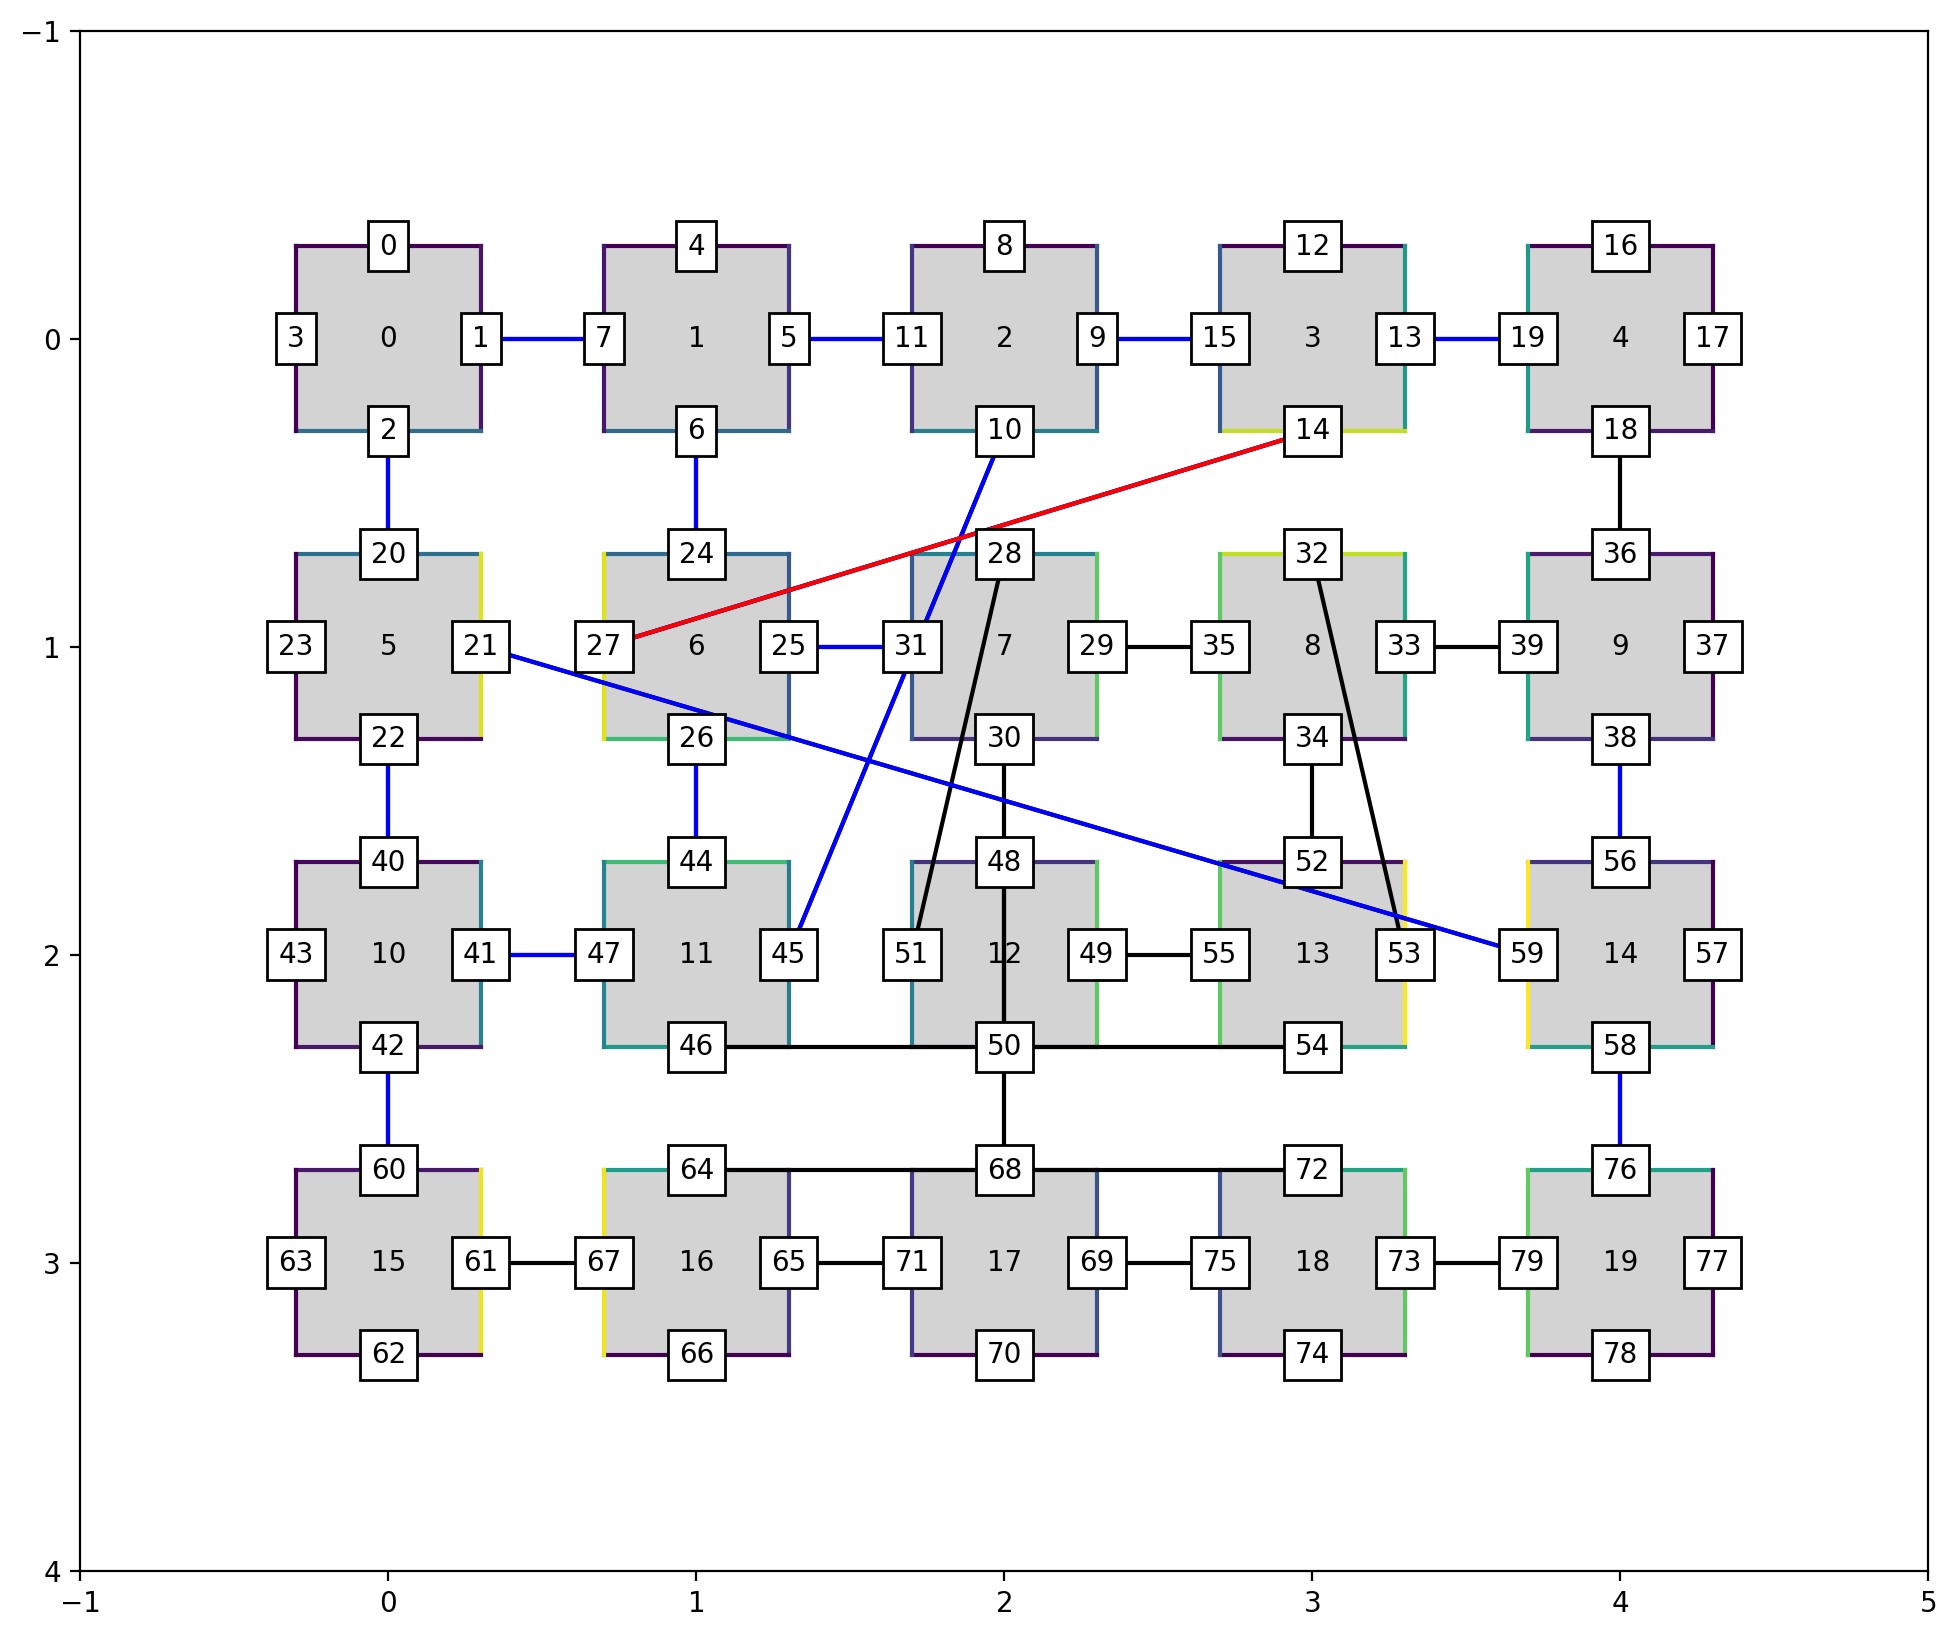

In [543]:
fig, ax = plt.subplots(dpi=200, figsize=(15, 10))
draw_jigsaw(ax)

# for src, tgt in edges:
#     ax.plot([vertex_pos[src][0], vertex_pos[tgt][0]], [vertex_pos[src][1], vertex_pos[tgt][1]], c="gray")

for src, tgt in matching:
    ax.plot([vertex_pos[src][0], vertex_pos[tgt][0]], [vertex_pos[src][1], vertex_pos[tgt][1]], c="black")

for src, tgt in visited_edges:
    ax.plot([vertex_pos[src][0], vertex_pos[tgt][0]], [vertex_pos[src][1], vertex_pos[tgt][1]], c="blue")

ax.plot([vertex_pos[error_src][0], vertex_pos[error_tgt][0]], [vertex_pos[error_src][1], vertex_pos[error_tgt][1]], c="red")

In [544]:
# Find shortest path containing the mismatch

In [545]:
# Step 1. Create tile graph

In [554]:
tile_graph = nx.Graph()
for src, tgt in visited_edges:
    if stuple((src, tgt)) != stuple((error_src, error_tgt)):
        tile_graph.add_edge(vt_lookup[src], vt_lookup[tgt])

In [555]:
tile_graph.edges

EdgeView([(0, 1), (0, 5), (1, 2), (1, 6), (5, 14), (5, 10), (2, 3), (2, 11), (6, 7), (6, 11), (14, 9), (14, 19), (10, 11), (10, 15), (3, 4)])

In [556]:
# Step 2. Find shortest path between conflicting vertices in tile graph

In [557]:
shortest_path_tile = nx.shortest_path(tile_graph, vt_lookup[error_src], vt_lookup[error_tgt])

In [558]:
shortest_path_tile

[3, 2, 1, 6]

In [559]:
# Step 3: Convert shortest path from tile graph to vertex graph

In [560]:
shortest_path = [(error_tgt, error_src)]

for i in range(len(shortest_path_tile) - 1):
    found_ = False
    for candidate in tv_lookup[shortest_path_tile[i]]:
        if vt_lookup.get(matching_lookup.get(candidate, None), None) == shortest_path_tile[i+1]:
            shortest_path.append((candidate, matching_lookup[candidate]))
            found_ = True
            break
    assert found_

In [561]:

shortest_path

[(27, 14), (15, 9), (11, 5), (6, 24)]

In [562]:
# Add constraint that edges in this path cannot be together in a valid solution
# c = sum(e1, ..., ep) < p for edges on shortest path (e1, ... , ep)

In [563]:
# Define MIP

In [564]:
adj_edges_lookup = defaultdict(list)

for i, (src, tgt) in enumerate(edges):
    adj_edges_lookup[src].append(i)
    adj_edges_lookup[tgt].append(i)

In [565]:
model = pyomo.ConcreteModel()
model.x = pyomo.Var(range(len(edges)), domain=pyomo.Binary)
model.obj = pyomo.Objective(expr=1)

model.matching_constraints = pyomo.ConstraintList()
for v, adj_edges in adj_edges_lookup.items():
    lhs = 0
    for e in adj_edges:
        lhs += model.x[e]
    model.matching_constraints.add(lhs == 1)

In [566]:
opt = pyomo.SolverFactory('glpk')
solution = opt.solve(model)

    solver failure.


In [567]:
solution = [bool(model.x[i].value) for i in range(len(edges))]
matching = np.array(edges)[solution]

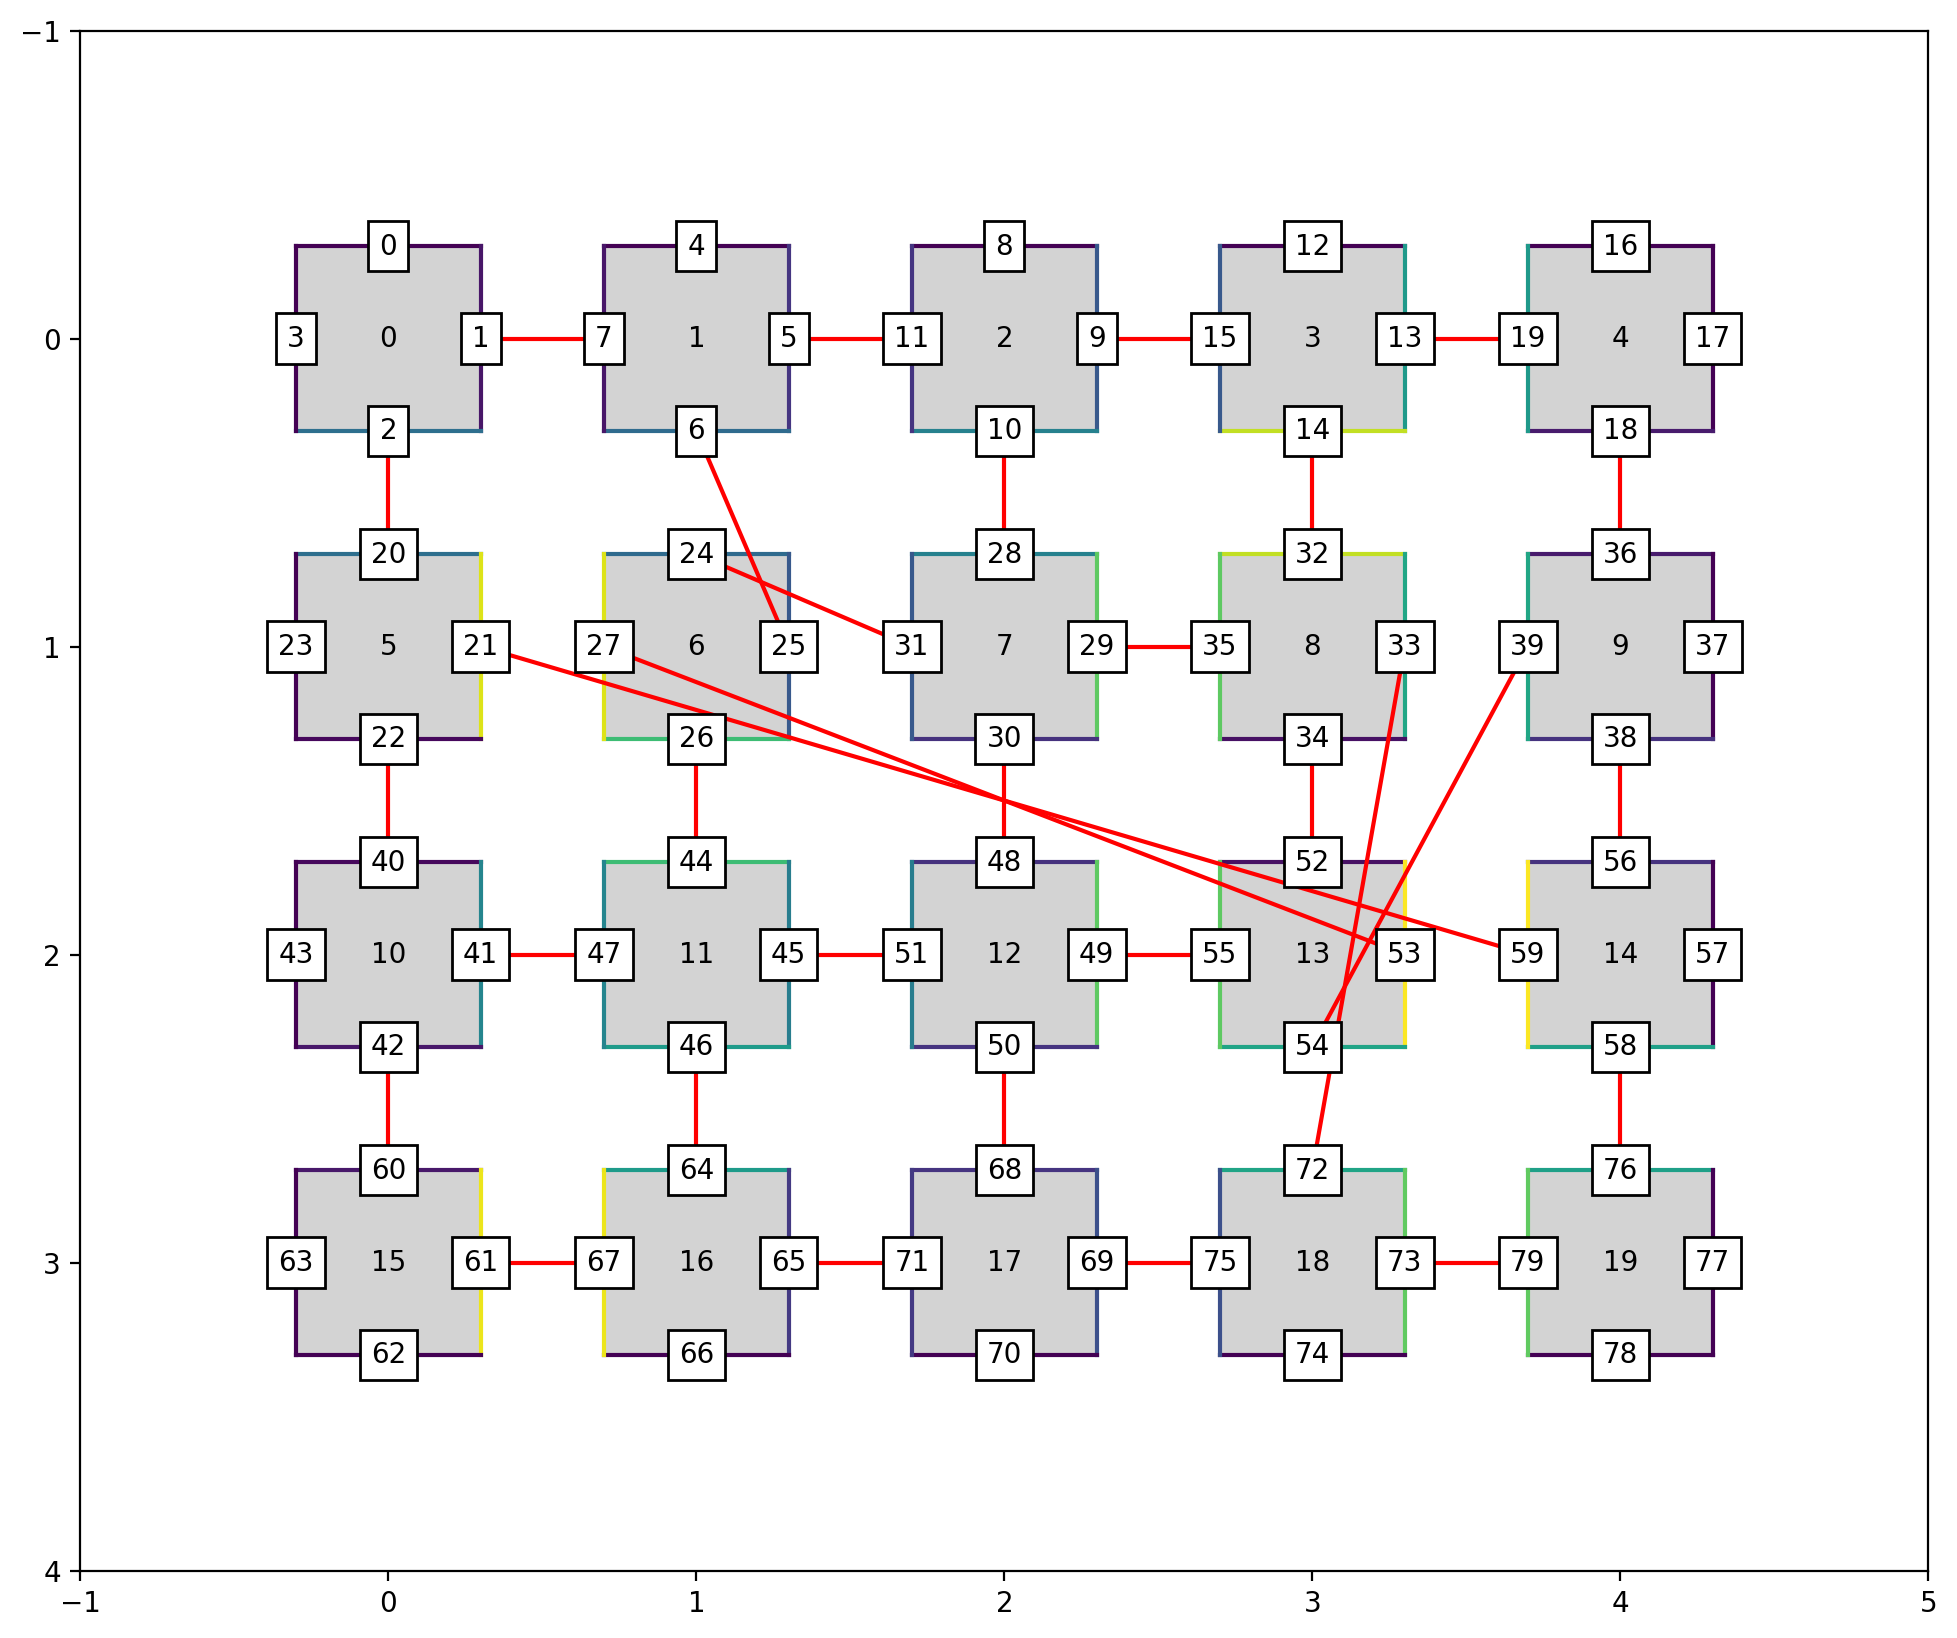

In [568]:
fig, ax = plt.subplots(dpi=200, figsize=(15, 10))
draw_jigsaw(ax)

# for src, tgt in edges:
#     ax.plot([vertex_pos[src][0], vertex_pos[tgt][0]], [vertex_pos[src][1], vertex_pos[tgt][1]], c="gray")

for src, tgt in matching:
    ax.plot([vertex_pos[src][0], vertex_pos[tgt][0]], [vertex_pos[src][1], vertex_pos[tgt][1]], c="red")

In [569]:
matching_lookup = {src: tgt for src, tgt in matching}
matching_lookup.update({tgt: src for src, tgt in matching})

In [570]:
stack = [matching[0][0]]
visited_tiles = set()
vertex_orientations = {
    stack[0]: ORIENTATIONS[stack[0] % 4], # Select specific start orientation for imore intuitive viualization. But any other orientation would also work.
} 
visited_edges = []
error_src, error_tgt = None, None

while len(stack) > 0:
    current_v = stack[0]

    tile_id = vt_lookup[current_v]
    tile_vertices = tv_lookup[tile_id]

    visited_tiles.add(tile_id)
    current_orientation = vertex_orientations[current_v]

    rotation = rotate_array(
        ORIENTATIONS,
        ORIENTATIONS.index(current_orientation) - np.where(tile_vertices == current_v)[0][0],
    )

    for src, rot in zip(tile_vertices, rotation):
        vertex_orientations[src] = rot

        tgt = matching_lookup.get(src, None)

        if tgt is not None: # Why it can be None???
            next_tile = vt_lookup[tgt]

            if next_tile in visited_tiles:
                if COUNTER_ORIENTATIONS[rot] != vertex_orientations[tgt]:
                    error_src = src
                    error_tgt = tgt
                    raise Exception(f"Orientation missmatch: Vertex {tgt} has ambiguous orientation: {COUNTER_ORIENTATIONS[rot]}, {vertex_orientations[tgt]} (Current vertex: {src})")
            else:
                stack.append(tgt)
                vertex_orientations[tgt] = COUNTER_ORIENTATIONS[rot]
                visited_edges.append(stuple((src, tgt)))
        if src in stack:
            stack.remove(src)


    # del stack[0]

Exception: Orientation missmatch: Vertex 5 has ambiguous orientation: N, S (Current vertex: 11)

In [571]:
visited_edges

[(24, 31),
 (6, 25),
 (26, 44),
 (27, 53),
 (10, 28),
 (29, 35),
 (30, 48),
 (5, 11),
 (1, 7),
 (45, 51),
 (46, 64),
 (41, 47),
 (34, 52),
 (39, 54),
 (49, 55),
 (9, 15)]

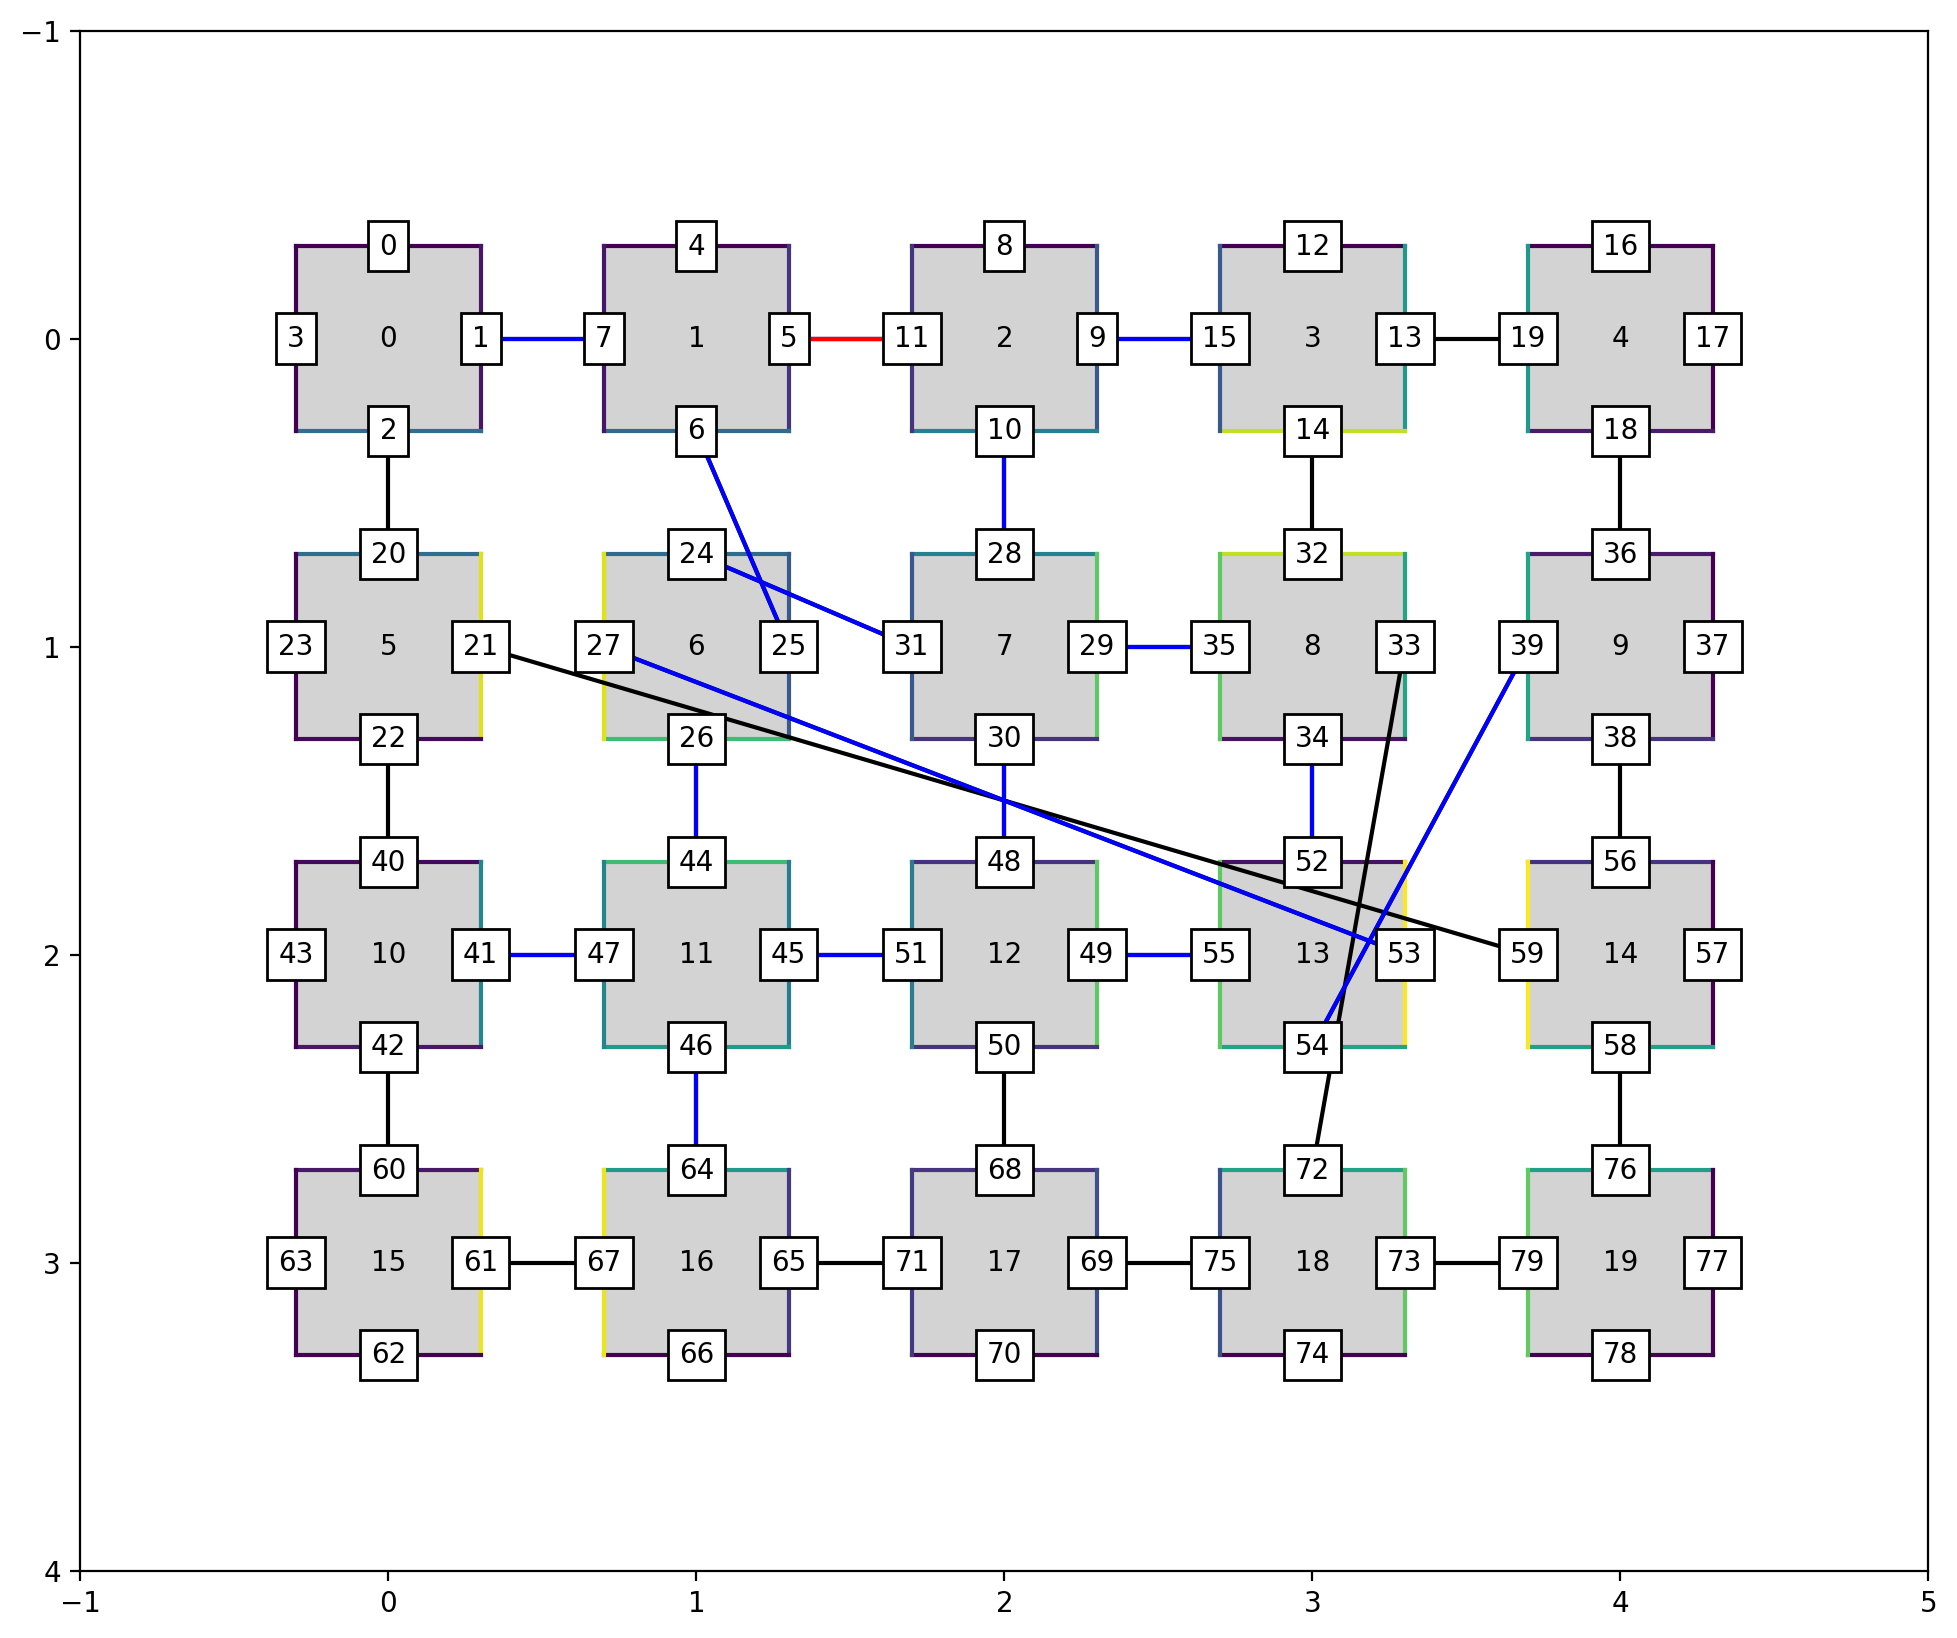

In [572]:
fig, ax = plt.subplots(dpi=200, figsize=(15, 10))
draw_jigsaw(ax)

# for src, tgt in edges:
#     ax.plot([vertex_pos[src][0], vertex_pos[tgt][0]], [vertex_pos[src][1], vertex_pos[tgt][1]], c="gray")

for src, tgt in matching:
    ax.plot([vertex_pos[src][0], vertex_pos[tgt][0]], [vertex_pos[src][1], vertex_pos[tgt][1]], c="black")

for src, tgt in visited_edges:
    ax.plot([vertex_pos[src][0], vertex_pos[tgt][0]], [vertex_pos[src][1], vertex_pos[tgt][1]], c="blue")

ax.plot([vertex_pos[error_src][0], vertex_pos[error_tgt][0]], [vertex_pos[error_src][1], vertex_pos[error_tgt][1]], c="red")

In [573]:
# Find shortest path containing the mismatch

In [574]:
# Step 1. Create tile graph

In [575]:
visited_edges

[(24, 31),
 (6, 25),
 (26, 44),
 (27, 53),
 (10, 28),
 (29, 35),
 (30, 48),
 (5, 11),
 (1, 7),
 (45, 51),
 (46, 64),
 (41, 47),
 (34, 52),
 (39, 54),
 (49, 55),
 (9, 15)]

In [576]:
tile_graph = nx.Graph()
for src, tgt in visited_edges:
    if stuple((src, tgt)) != stuple((error_src, error_tgt)):
        tile_graph.add_edge(vt_lookup[src], vt_lookup[tgt])

In [577]:
tile_graph.edges

EdgeView([(6, 7), (6, 1), (6, 11), (6, 13), (7, 2), (7, 8), (7, 12), (1, 0), (11, 12), (11, 16), (11, 10), (13, 8), (13, 9), (13, 12), (2, 3)])

In [578]:
# Step 2. Find shortest path between conflicting vertices in tile graph

In [579]:
shortest_path_tile = nx.shortest_path(tile_graph, vt_lookup[error_src], vt_lookup[error_tgt])

In [580]:
shortest_path_tile

[2, 7, 6, 1]

In [581]:
# Step 3: Convert shortest path from tile graph to vertex graph

In [582]:
shortest_path = [(error_tgt, error_src)]

for i in range(len(shortest_path_tile) - 1):
    found_ = False
    for candidate in tv_lookup[shortest_path_tile[i]]:
        if vt_lookup.get(matching_lookup.get(candidate, None), None) == shortest_path_tile[i+1]:
            shortest_path.append((candidate, matching_lookup[candidate]))
            found_ = True
            break
    assert found_

In [583]:
# shortest_path = [stuple(el) for el in shortest_path]
shortest_path

[(5, 11), (10, 28), (31, 24), (25, 6)]

In [584]:
# Add constraint
model.orientation_constraints = pyomo.ConstraintList()
lhs = 0
for e in shortest_path:
    lhs += model.x[edges.index(stuple(e))]
model.orientation_constraints.add(lhs <= len(shortest_path) - 1)

In [585]:
solution = opt.solve(model)

    solver failure.


In [586]:
solution = [bool(model.x[i].value) for i in range(len(edges))]
matching = np.array(edges)[solution]

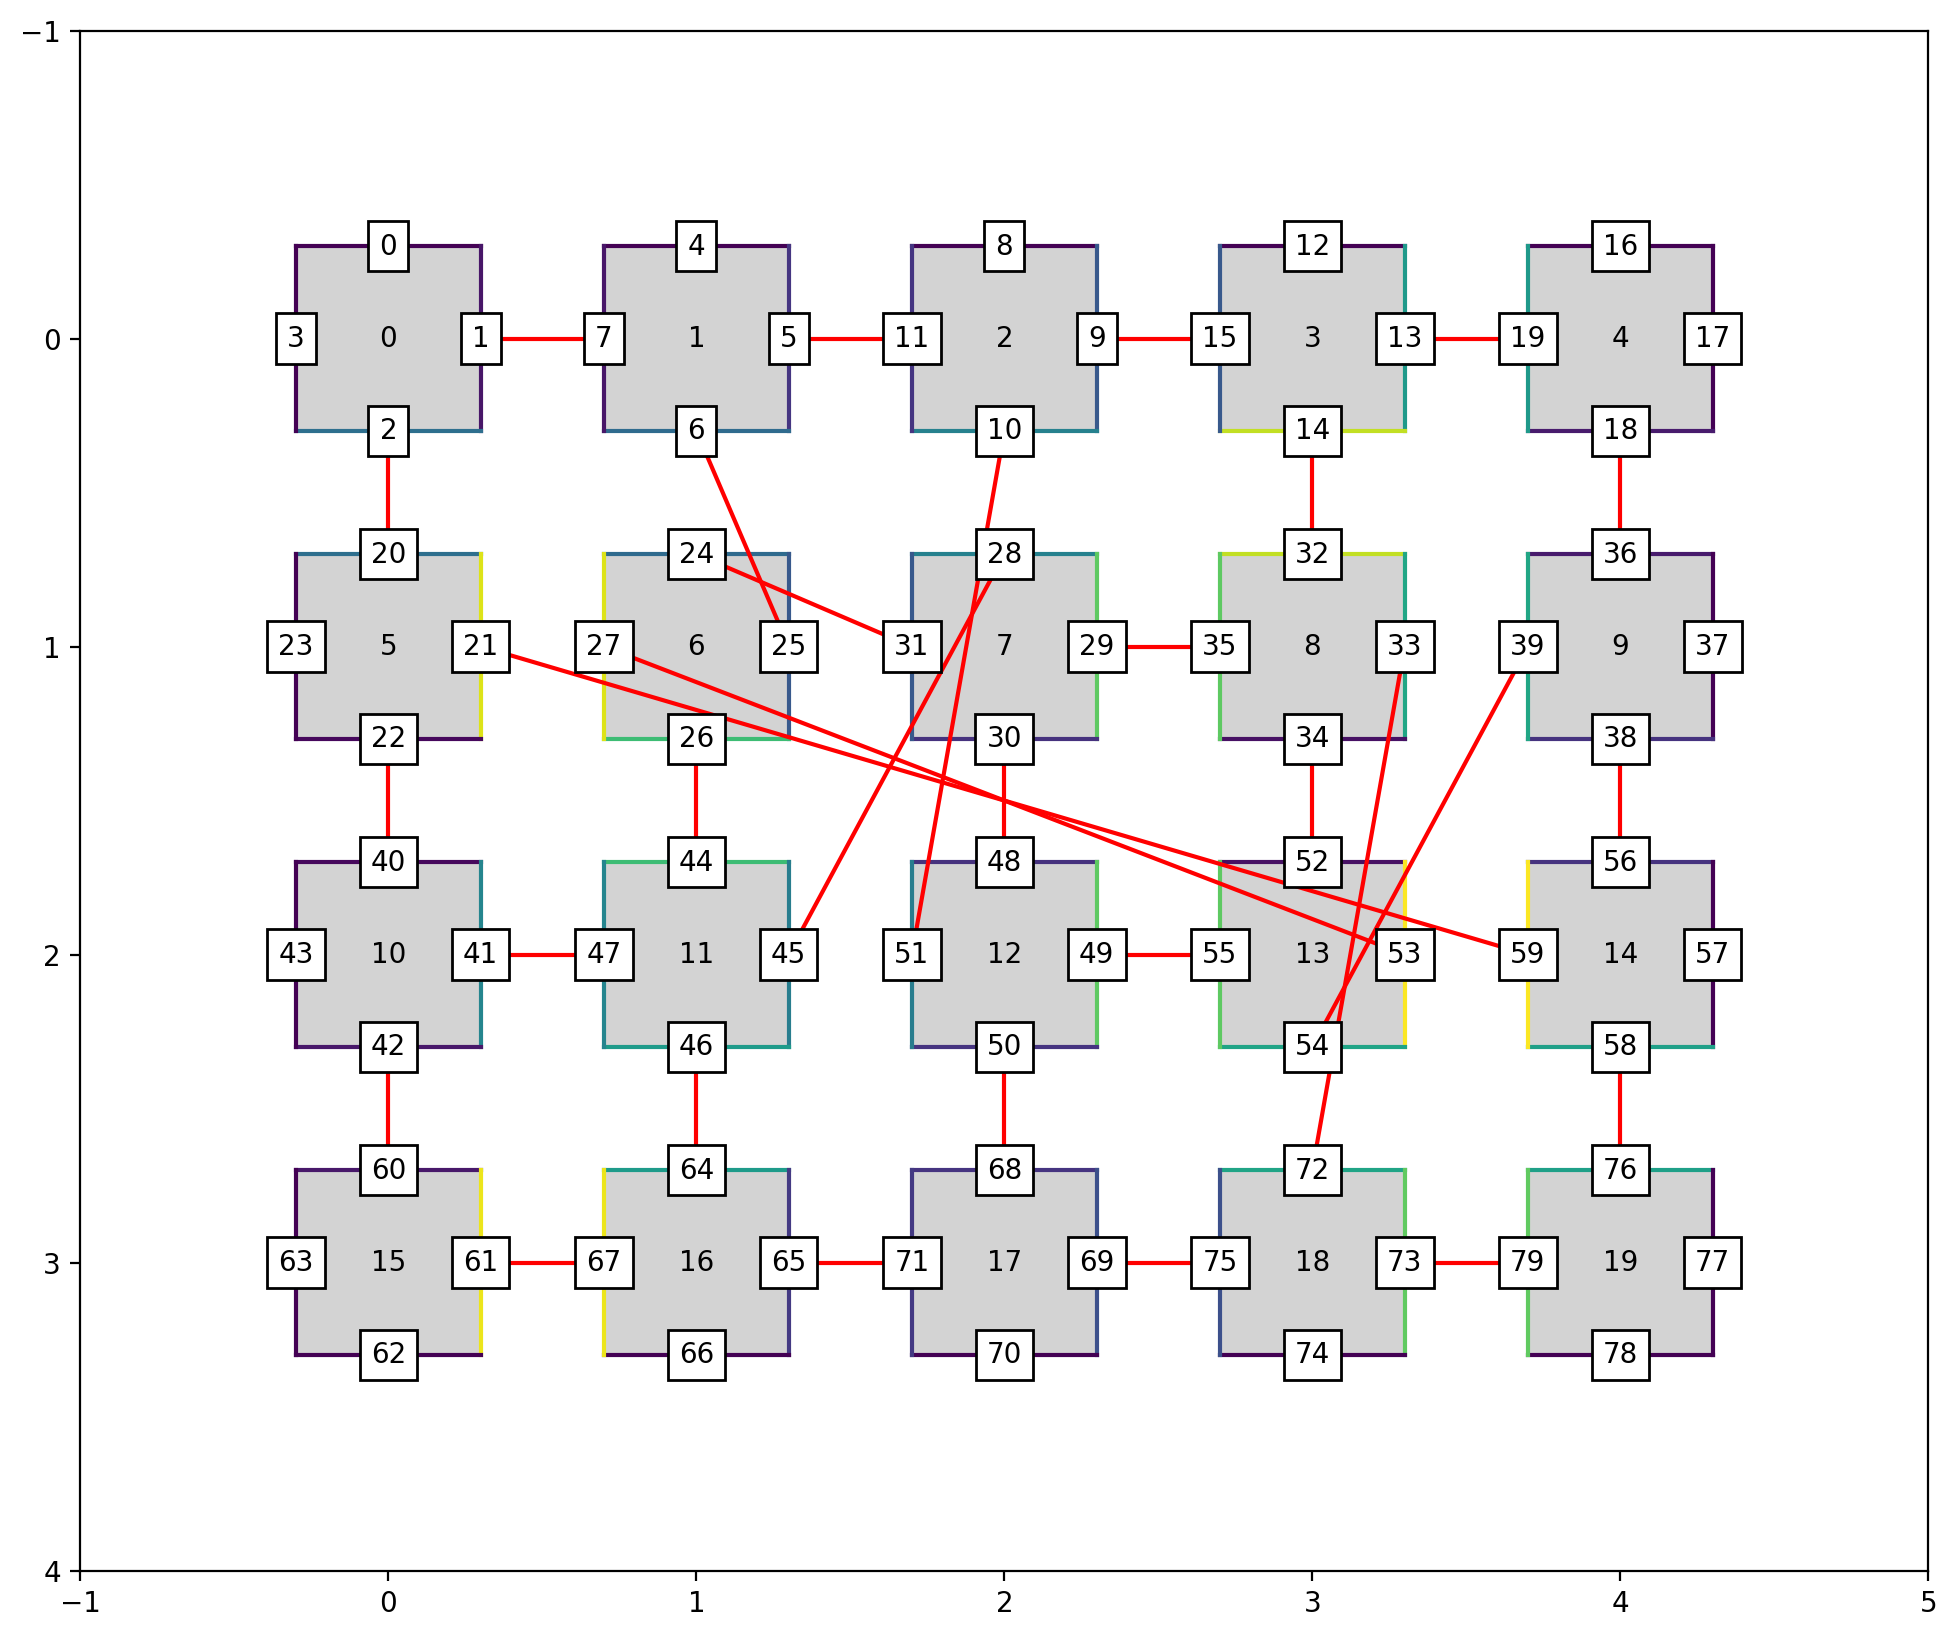

In [587]:
fig, ax = plt.subplots(dpi=200, figsize=(15, 10))
draw_jigsaw(ax)

# for src, tgt in edges:
#     ax.plot([vertex_pos[src][0], vertex_pos[tgt][0]], [vertex_pos[src][1], vertex_pos[tgt][1]], c="gray")

for src, tgt in matching:
    ax.plot([vertex_pos[src][0], vertex_pos[tgt][0]], [vertex_pos[src][1], vertex_pos[tgt][1]], c="red")

In [588]:
matching_lookup = {src: tgt for src, tgt in matching}
matching_lookup.update({tgt: src for src, tgt in matching})

In [589]:
stack = [matching[0][0]]
visited_tiles = set()
vertex_orientations = {
    stack[0]: ORIENTATIONS[stack[0] % 4], # Select specific start orientation for imore intuitive viualization. But any other orientation would also work.
} 
visited_edges = []
error_src, error_tgt = None, None

while len(stack) > 0:
    current_v = stack[0]

    tile_id = vt_lookup[current_v]
    tile_vertices = tv_lookup[tile_id]

    visited_tiles.add(tile_id)
    current_orientation = vertex_orientations[current_v]

    rotation = rotate_array(
        ORIENTATIONS,
        ORIENTATIONS.index(current_orientation) - np.where(tile_vertices == current_v)[0][0],
    )

    for src, rot in zip(tile_vertices, rotation):
        vertex_orientations[src] = rot

        tgt = matching_lookup.get(src, None)

        if tgt is not None: # Why it can be None???
            next_tile = vt_lookup[tgt]

            if next_tile in visited_tiles:
                if COUNTER_ORIENTATIONS[rot] != vertex_orientations[tgt]:
                    error_src = src
                    error_tgt = tgt
                    raise Exception(f"Orientation missmatch: Vertex {tgt} has ambiguous orientation: {COUNTER_ORIENTATIONS[rot]}, {vertex_orientations[tgt]} (Current vertex: {src})")
            else:
                stack.append(tgt)
                visited_edges.append(stuple((src, tgt)))
                vertex_orientations[tgt] = COUNTER_ORIENTATIONS[rot]
        if src in stack:
            stack.remove(src)


    # del stack[0]

Exception: Orientation missmatch: Vertex 52 has ambiguous orientation: W, N (Current vertex: 34)

In [590]:
tile_graph = nx.Graph()
for src, tgt in visited_edges:
    if stuple((src, tgt)) != stuple((error_src, error_tgt)):
        tile_graph.add_edge(vt_lookup[src], vt_lookup[tgt])

In [591]:
tile_graph.edges

EdgeView([(6, 7), (6, 1), (6, 11), (6, 13), (7, 11), (7, 8), (7, 12), (1, 2), (1, 0), (11, 16), (11, 10), (13, 9), (13, 12), (8, 3), (8, 18)])

In [592]:
# Step 2. Find shortest path between conflicting vertices in tile graph

In [593]:
shortest_path_tile = nx.shortest_path(tile_graph, vt_lookup[error_src], vt_lookup[error_tgt])

In [594]:
shortest_path_tile

[8, 7, 6, 13]

In [595]:
# Step 3: Convert shortest path from tile graph to cycle in vertex graph

In [596]:
shortest_path = [(error_tgt, error_src)]

for i in range(len(shortest_path_tile) - 1):
    found_ = False
    for candidate in tv_lookup[shortest_path_tile[i]]:
        if vt_lookup.get(matching_lookup.get(candidate, None), None) == shortest_path_tile[i+1]:
            shortest_path.append((candidate, matching_lookup[candidate]))
            found_ = True
            break
    assert found_

In [597]:
# shortest_path = [stuple(el) for el in shortest_path]
shortest_path

[(52, 34), (35, 29), (31, 24), (27, 53)]

In [598]:
# Add constraint
# model.orientation_constraints = pyomo.ConstraintList()
lhs = 0
for e in shortest_path:
    lhs += model.x[edges.index(stuple(e))]
model.orientation_constraints.add(lhs <= len(shortest_path) - 1)

In [599]:
solution = opt.solve(model)

    solver failure.


In [601]:
solution = [bool(model.x[i].value) for i in range(len(edges))]
matching = np.array(edges)[solution]

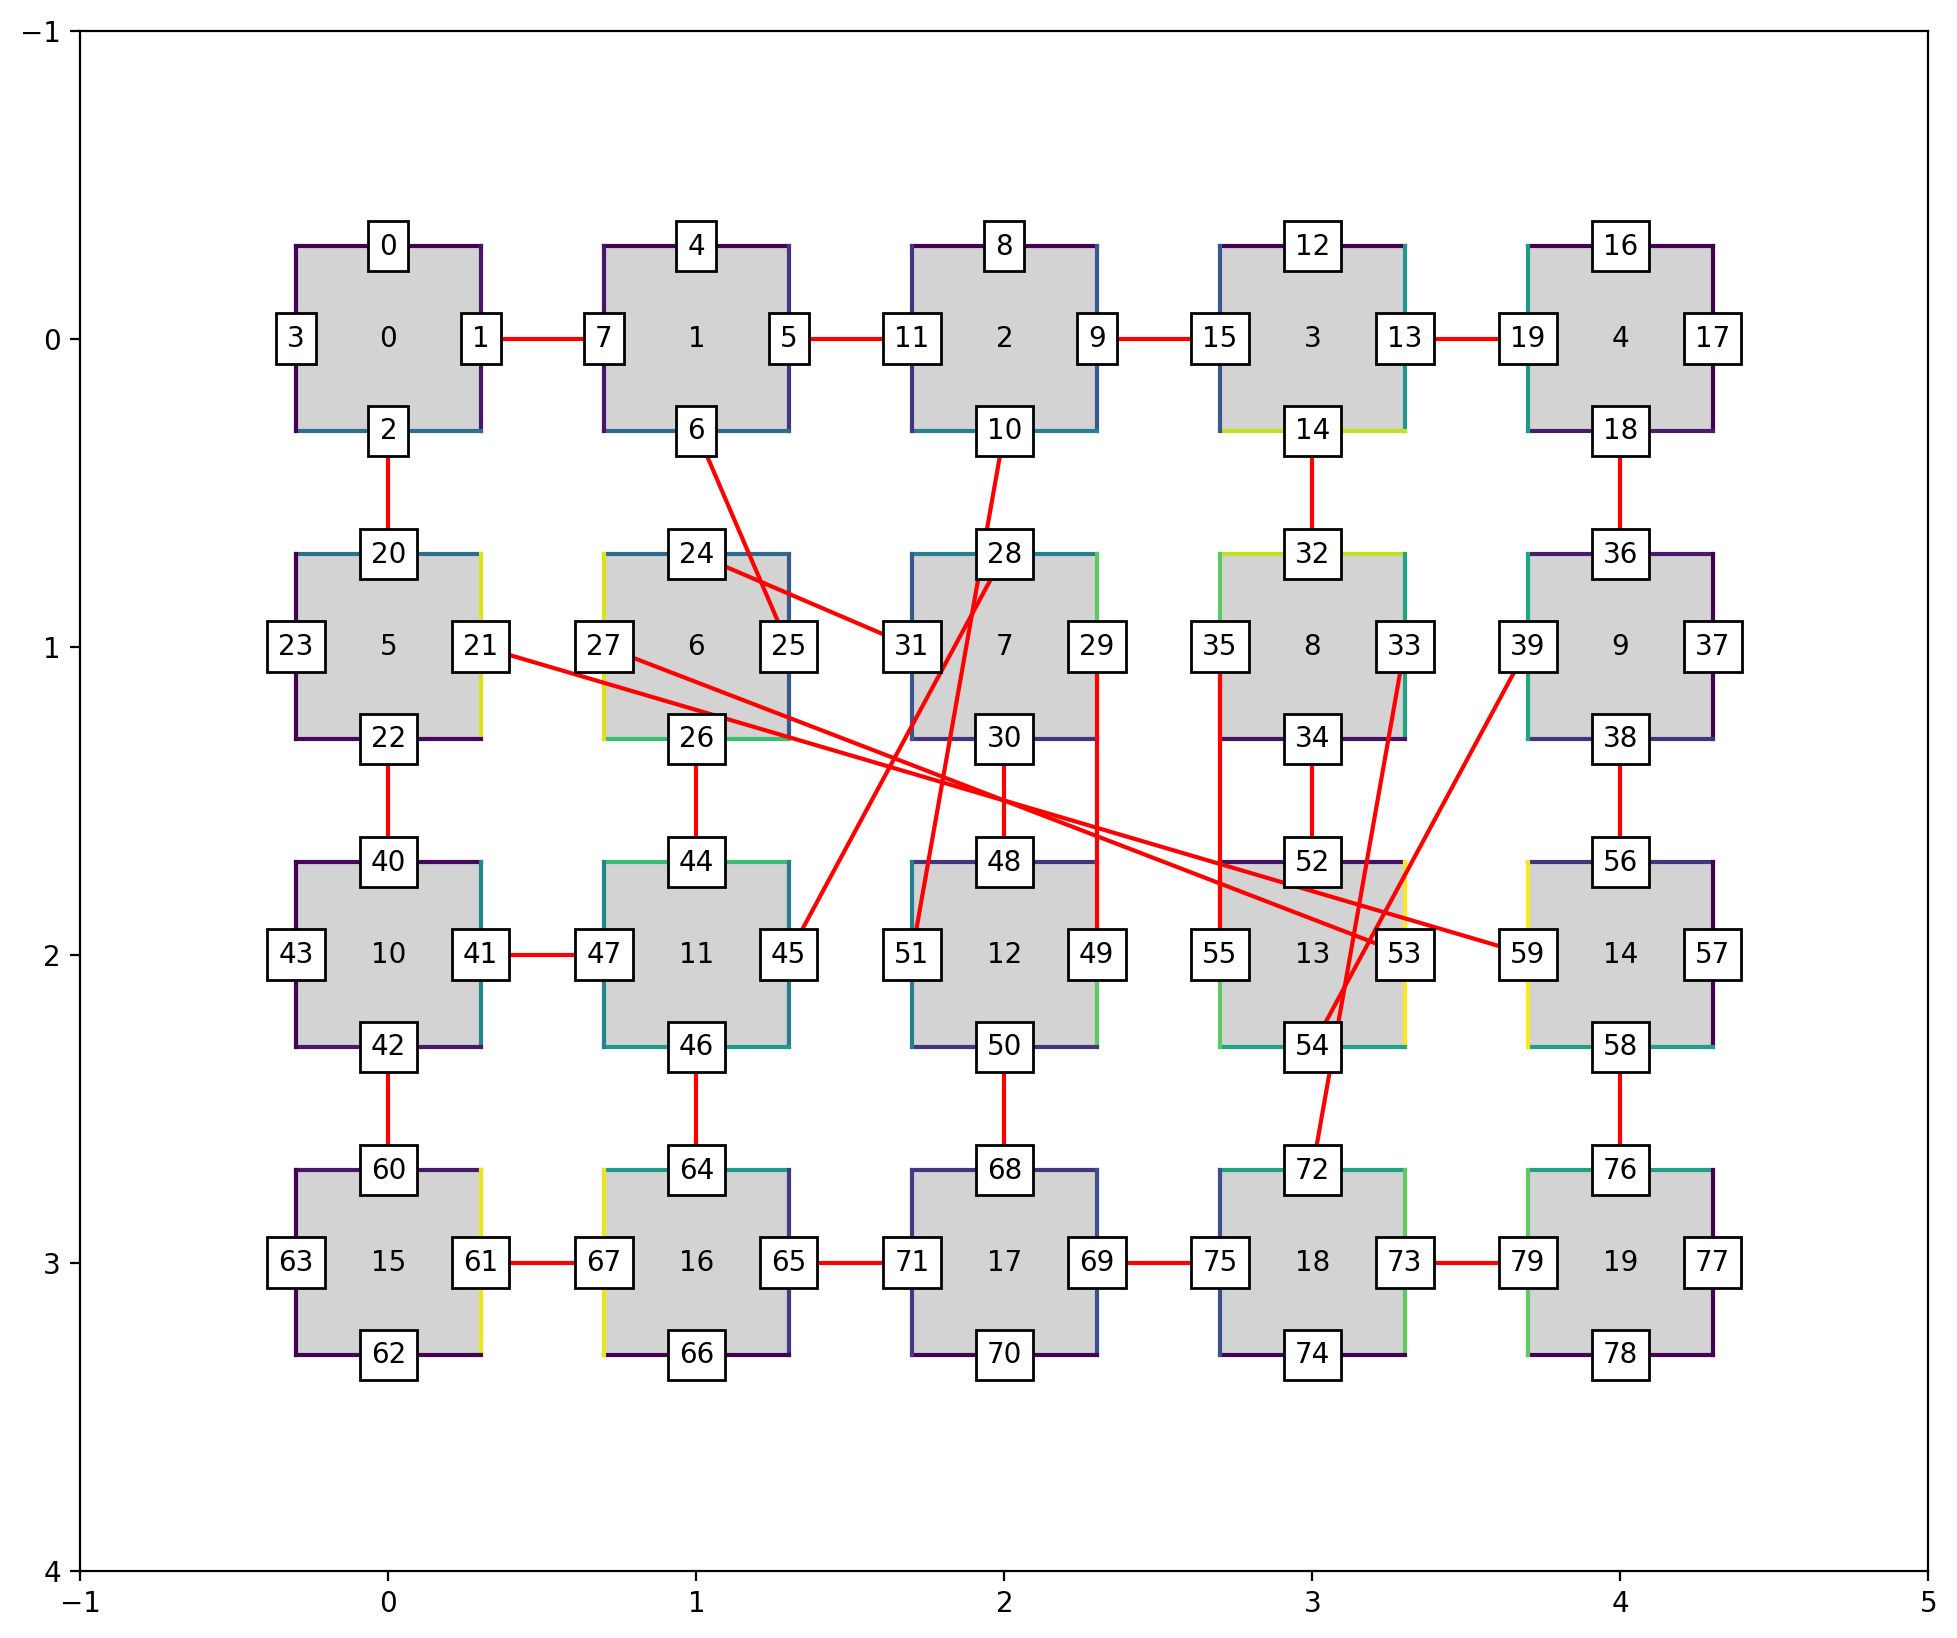

In [602]:
fig, ax = plt.subplots(dpi=200, figsize=(15, 10))
draw_jigsaw(ax)

# for src, tgt in edges:
#     ax.plot([vertex_pos[src][0], vertex_pos[tgt][0]], [vertex_pos[src][1], vertex_pos[tgt][1]], c="gray")

for src, tgt in matching:
    ax.plot([vertex_pos[src][0], vertex_pos[tgt][0]], [vertex_pos[src][1], vertex_pos[tgt][1]], c="red")

In [603]:
matching_lookup = {src: tgt for src, tgt in matching}
matching_lookup.update({tgt: src for src, tgt in matching})

In [604]:
stack = [matching[0][0]]
visited_tiles = set()
vertex_orientations = {
    stack[0]: ORIENTATIONS[stack[0] % 4], # Select specific start orientation for imore intuitive viualization. But any other orientation would also work.
} 
visited_edges = []
error_src, error_tgt = None, None

while len(stack) > 0:
    current_v = stack[0]

    tile_id = vt_lookup[current_v]
    tile_vertices = tv_lookup[tile_id]

    visited_tiles.add(tile_id)
    current_orientation = vertex_orientations[current_v]

    rotation = rotate_array(
        ORIENTATIONS,
        ORIENTATIONS.index(current_orientation) - np.where(tile_vertices == current_v)[0][0],
    )

    for src, rot in zip(tile_vertices, rotation):
        vertex_orientations[src] = rot

        tgt = matching_lookup.get(src, None)

        if tgt is not None: # Why it can be None???
            next_tile = vt_lookup[tgt]

            if next_tile in visited_tiles:
                if COUNTER_ORIENTATIONS[rot] != vertex_orientations[tgt]:
                    error_src = src
                    error_tgt = tgt
                    raise Exception(f"Orientation missmatch: Vertex {tgt} has ambiguous orientation: {COUNTER_ORIENTATIONS[rot]}, {vertex_orientations[tgt]} (Current vertex: {src})")
            else:
                stack.append(tgt)
                visited_edges.append(stuple((src, tgt)))
                vertex_orientations[tgt] = COUNTER_ORIENTATIONS[rot]
        if src in stack:
            stack.remove(src)


    # del stack[0]

Exception: Orientation missmatch: Vertex 30 has ambiguous orientation: W, E (Current vertex: 48)

In [605]:
tile_graph = nx.Graph()
for src, tgt in visited_edges:
    if stuple((src, tgt)) != stuple((error_src, error_tgt)):
        tile_graph.add_edge(vt_lookup[src], vt_lookup[tgt])

In [606]:
tile_graph.edges

EdgeView([(6, 7), (6, 1), (6, 11), (6, 13), (7, 11), (7, 12), (1, 2), (1, 0), (11, 16), (11, 10), (13, 8), (13, 9)])

In [607]:
# Step 2. Find shortest path between conflicting vertices in tile graph

In [608]:
shortest_path_tile = nx.shortest_path(tile_graph, vt_lookup[error_src], vt_lookup[error_tgt])

In [609]:
shortest_path_tile

[12, 7]

In [610]:
# Step 3: Convert shortest path from tile graph to cycle in vertex graph

In [611]:
shortest_path = [(error_tgt, error_src)]

for i in range(len(shortest_path_tile) - 1):
    found_ = False
    for candidate in tv_lookup[shortest_path_tile[i]]:
        if vt_lookup.get(matching_lookup.get(candidate, None), None) == shortest_path_tile[i+1]:
            shortest_path.append((candidate, matching_lookup[candidate]))
            found_ = True
            break
    assert found_

In [612]:
# shortest_path = [stuple(el) for el in shortest_path]
shortest_path

[(30, 48), (48, 30)]

In [613]:
# Add constraint
# model.orientation_constraints = pyomo.ConstraintList()
lhs = 0
for e in shortest_path:
    lhs += model.x[edges.index(stuple(e))]
model.orientation_constraints.add(lhs <= len(shortest_path) - 1)

In [614]:
solution = opt.solve(model)

    solver failure.


In [615]:
solution = [bool(model.x[i].value) for i in range(len(edges))]
matching = np.array(edges)[solution]

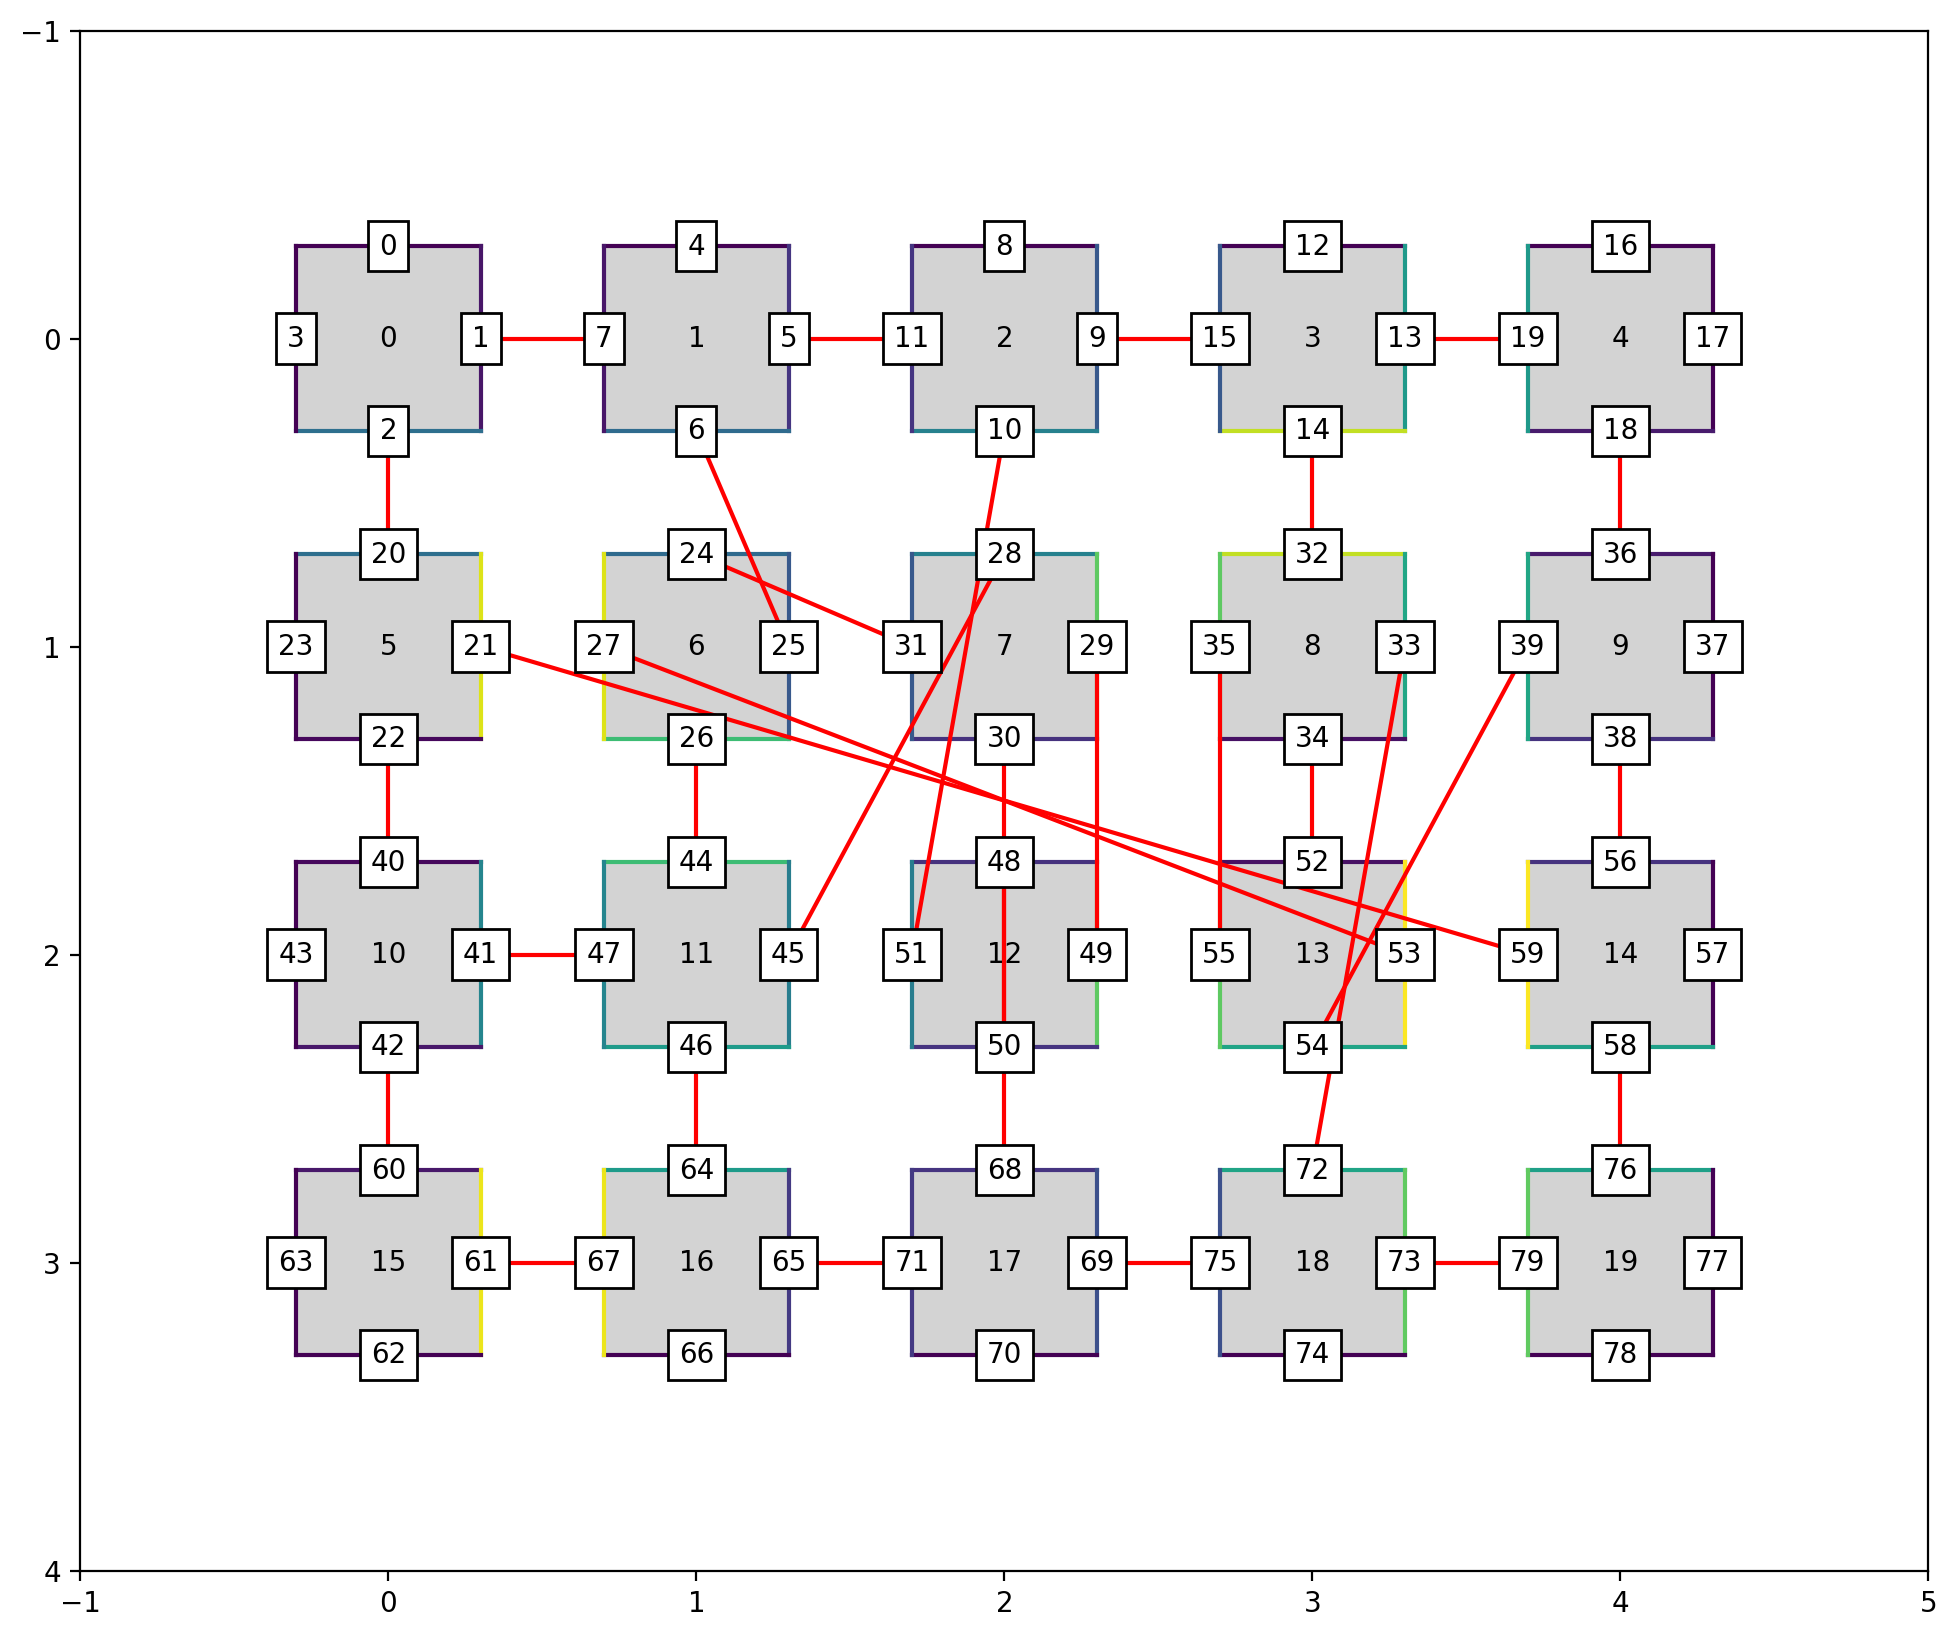

In [616]:
fig, ax = plt.subplots(dpi=200, figsize=(15, 10))
draw_jigsaw(ax)

# for src, tgt in edges:
#     ax.plot([vertex_pos[src][0], vertex_pos[tgt][0]], [vertex_pos[src][1], vertex_pos[tgt][1]], c="gray")

for src, tgt in matching:
    ax.plot([vertex_pos[src][0], vertex_pos[tgt][0]], [vertex_pos[src][1], vertex_pos[tgt][1]], c="red")

In [617]:
matching_lookup = {src: tgt for src, tgt in matching}
matching_lookup.update({tgt: src for src, tgt in matching})

In [618]:
stack = [matching[0][0]]
visited_tiles = set()
vertex_orientations = {
    stack[0]: ORIENTATIONS[stack[0] % 4], # Select specific start orientation for imore intuitive viualization. But any other orientation would also work.
} 
visited_edges = []
error_src, error_tgt = None, None

while len(stack) > 0:
    current_v = stack[0]

    tile_id = vt_lookup[current_v]
    tile_vertices = tv_lookup[tile_id]

    visited_tiles.add(tile_id)
    current_orientation = vertex_orientations[current_v]

    rotation = rotate_array(
        ORIENTATIONS,
        ORIENTATIONS.index(current_orientation) - np.where(tile_vertices == current_v)[0][0],
    )

    for src, rot in zip(tile_vertices, rotation):
        vertex_orientations[src] = rot

        tgt = matching_lookup.get(src, None)

        if tgt is not None: # Why it can be None???
            next_tile = vt_lookup[tgt]

            if next_tile in visited_tiles:
                if COUNTER_ORIENTATIONS[rot] != vertex_orientations[tgt]:
                    error_src = src
                    error_tgt = tgt
                    raise Exception(f"Orientation missmatch: Vertex {tgt} has ambiguous orientation: {COUNTER_ORIENTATIONS[rot]}, {vertex_orientations[tgt]} (Current vertex: {src})")
            else:
                stack.append(tgt)
                visited_edges.append(stuple((src, tgt)))
                vertex_orientations[tgt] = COUNTER_ORIENTATIONS[rot]
        if src in stack:
            stack.remove(src)


    # del stack[0]

Exception: Orientation missmatch: Vertex 51 has ambiguous orientation: E, N (Current vertex: 10)

In [ ]:
tile_graph = nx.Graph()
for src, tgt in visited_edges:
    if stuple((src, tgt)) != stuple((error_src, error_tgt)):
        tile_graph.add_edge(vt_lookup[src], vt_lookup[tgt])

In [ ]:
tile_graph.edges

EdgeView([(6, 7), (6, 1), (6, 11), (6, 13), (7, 11), (7, 8), (7, 12), (1, 2), (1, 0), (11, 16), (11, 10), (13, 9), (13, 12), (8, 3), (8, 18)])

In [ ]:
# Step 2. Find shortest path between conflicting vertices in tile graph

In [ ]:
shortest_path_tile = nx.shortest_path(tile_graph, vt_lookup[error_src], vt_lookup[error_tgt])

In [619]:
shortest_path_tile

[12, 7]

In [620]:
# Step 3: Convert shortest path from tile graph to cycle in vertex graph

In [621]:
shortest_path = [(error_tgt, error_src)]

for i in range(len(shortest_path_tile) - 1):
    found_ = False
    for candidate in tv_lookup[shortest_path_tile[i]]:
        if vt_lookup.get(matching_lookup.get(candidate, None), None) == shortest_path_tile[i+1]:
            shortest_path.append((candidate, matching_lookup[candidate]))
            found_ = True
            break
    assert found_

In [622]:
# shortest_path = [stuple(el) for el in shortest_path]
shortest_path

[(51, 10), (49, 29)]

In [623]:
# Add constraint
# model.orientation_constraints = pyomo.ConstraintList()
lhs = 0
for e in shortest_path:
    lhs += model.x[edges.index(stuple(e))]
model.orientation_constraints.add(lhs <= len(shortest_path) - 1)

In [624]:
solution = opt.solve(model)

    solver failure.


In [625]:
solution = [bool(model.x[i].value) for i in range(len(edges))]
matching = np.array(edges)[solution]

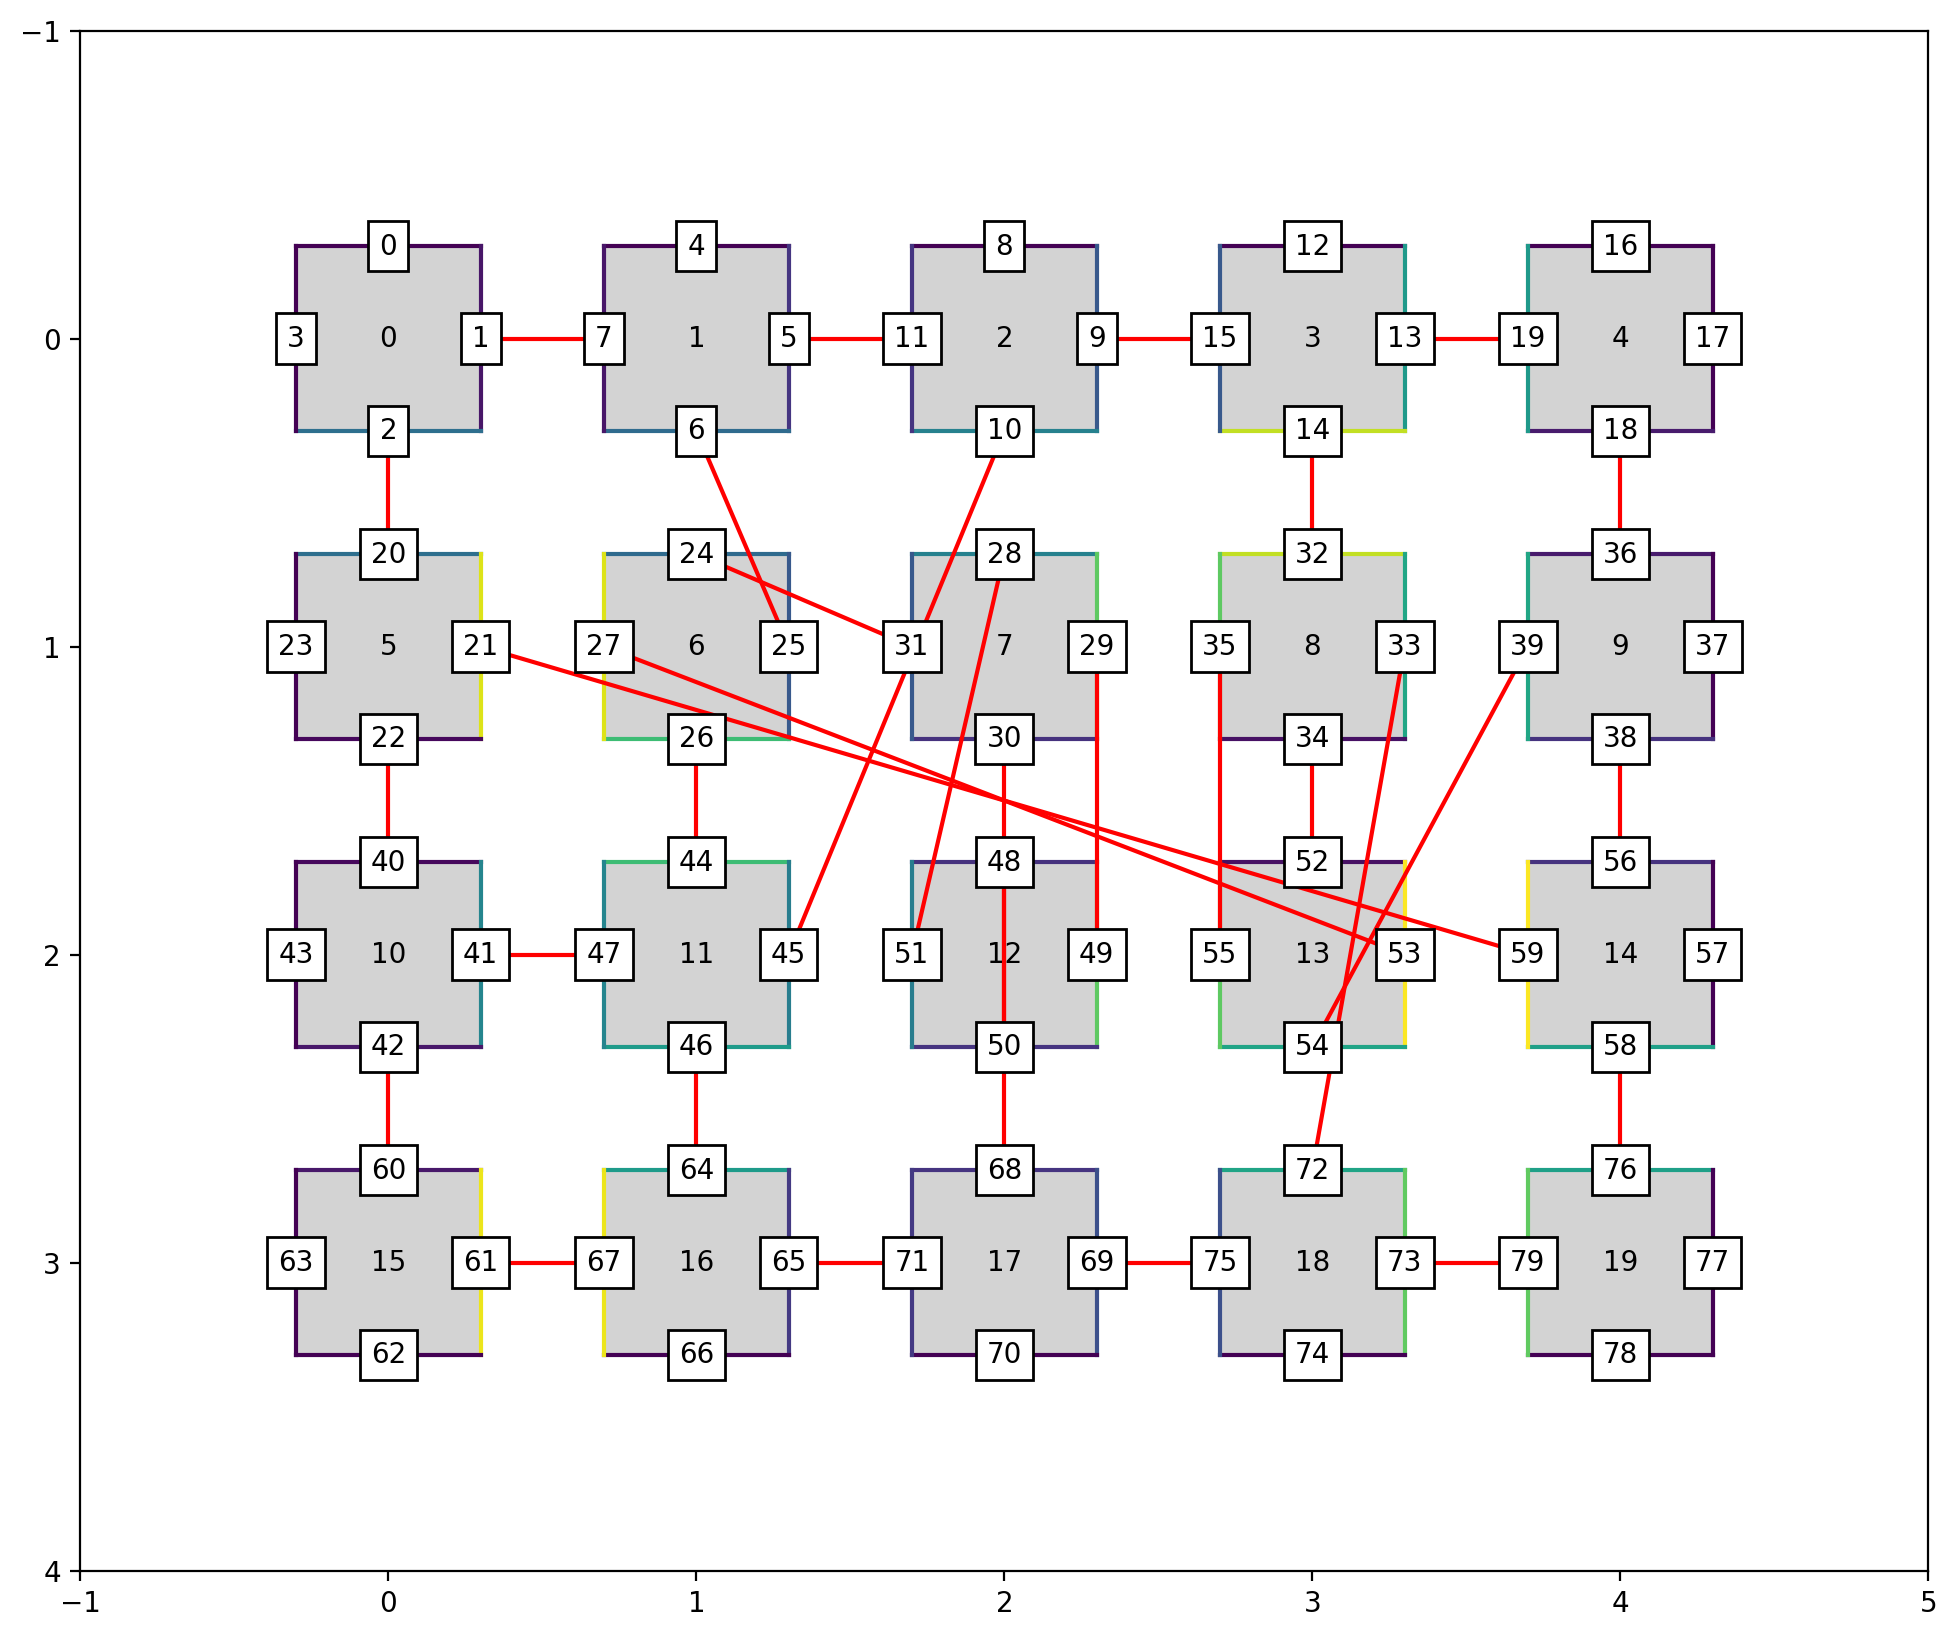

In [626]:
fig, ax = plt.subplots(dpi=200, figsize=(15, 10))
draw_jigsaw(ax)

# for src, tgt in edges:
#     ax.plot([vertex_pos[src][0], vertex_pos[tgt][0]], [vertex_pos[src][1], vertex_pos[tgt][1]], c="gray")

for src, tgt in matching:
    ax.plot([vertex_pos[src][0], vertex_pos[tgt][0]], [vertex_pos[src][1], vertex_pos[tgt][1]], c="red")

In [627]:
matching_lookup = {src: tgt for src, tgt in matching}
matching_lookup.update({tgt: src for src, tgt in matching})

In [628]:
stack = [matching[0][0]]
visited_tiles = set()
vertex_orientations = {
    stack[0]: ORIENTATIONS[stack[0] % 4], # Select specific start orientation for imore intuitive viualization. But any other orientation would also work.
} 
visited_edges = []
error_src, error_tgt = None, None

while len(stack) > 0:
    current_v = stack[0]

    tile_id = vt_lookup[current_v]
    tile_vertices = tv_lookup[tile_id]

    visited_tiles.add(tile_id)
    current_orientation = vertex_orientations[current_v]

    rotation = rotate_array(
        ORIENTATIONS,
        ORIENTATIONS.index(current_orientation) - np.where(tile_vertices == current_v)[0][0],
    )

    for src, rot in zip(tile_vertices, rotation):
        vertex_orientations[src] = rot

        tgt = matching_lookup.get(src, None)

        if tgt is not None: # Why it can be None???
            next_tile = vt_lookup[tgt]

            if next_tile in visited_tiles:
                if COUNTER_ORIENTATIONS[rot] != vertex_orientations[tgt]:
                    error_src = src
                    error_tgt = tgt
                    raise Exception(f"Orientation missmatch: Vertex {tgt} has ambiguous orientation: {COUNTER_ORIENTATIONS[rot]}, {vertex_orientations[tgt]} (Current vertex: {src})")
            else:
                stack.append(tgt)
                visited_edges.append(stuple((src, tgt)))
                vertex_orientations[tgt] = COUNTER_ORIENTATIONS[rot]
        if src in stack:
            stack.remove(src)


    # del stack[0]

Exception: Orientation missmatch: Vertex 29 has ambiguous orientation: E, N (Current vertex: 49)

In [ ]:
tile_graph = nx.Graph()
for src, tgt in visited_edges:
    if stuple((src, tgt)) != stuple((error_src, error_tgt)):
        tile_graph.add_edge(vt_lookup[src], vt_lookup[tgt])

In [ ]:
tile_graph.edges

EdgeView([(6, 7), (6, 1), (6, 11), (6, 13), (7, 11), (7, 8), (7, 12), (1, 2), (1, 0), (11, 16), (11, 10), (13, 9), (13, 12), (8, 3), (8, 18)])

In [ ]:
# Step 2. Find shortest path between conflicting vertices in tile graph

In [ ]:
shortest_path_tile = nx.shortest_path(tile_graph, vt_lookup[error_src], vt_lookup[error_tgt])

In [629]:
shortest_path_tile

[12, 7]

In [630]:
# Step 3: Convert shortest path from tile graph to cycle in vertex graph

In [631]:
shortest_path = [(error_tgt, error_src)]

for i in range(len(shortest_path_tile) - 1):
    found_ = False
    for candidate in tv_lookup[shortest_path_tile[i]]:
        if vt_lookup.get(matching_lookup.get(candidate, None), None) == shortest_path_tile[i+1]:
            shortest_path.append((candidate, matching_lookup[candidate]))
            found_ = True
            break
    assert found_

In [632]:
# shortest_path = [stuple(el) for el in shortest_path]
shortest_path

[(29, 49), (49, 29)]

In [633]:
# Add constraint
# model.orientation_constraints = pyomo.ConstraintList()
lhs = 0
for e in shortest_path:
    lhs += model.x[edges.index(stuple(e))]
model.orientation_constraints.add(lhs <= len(shortest_path) - 1)

In [634]:
solution = opt.solve(model)

    solver failure.


In [635]:
solution = [bool(model.x[i].value) for i in range(len(edges))]
matching = np.array(edges)[solution]

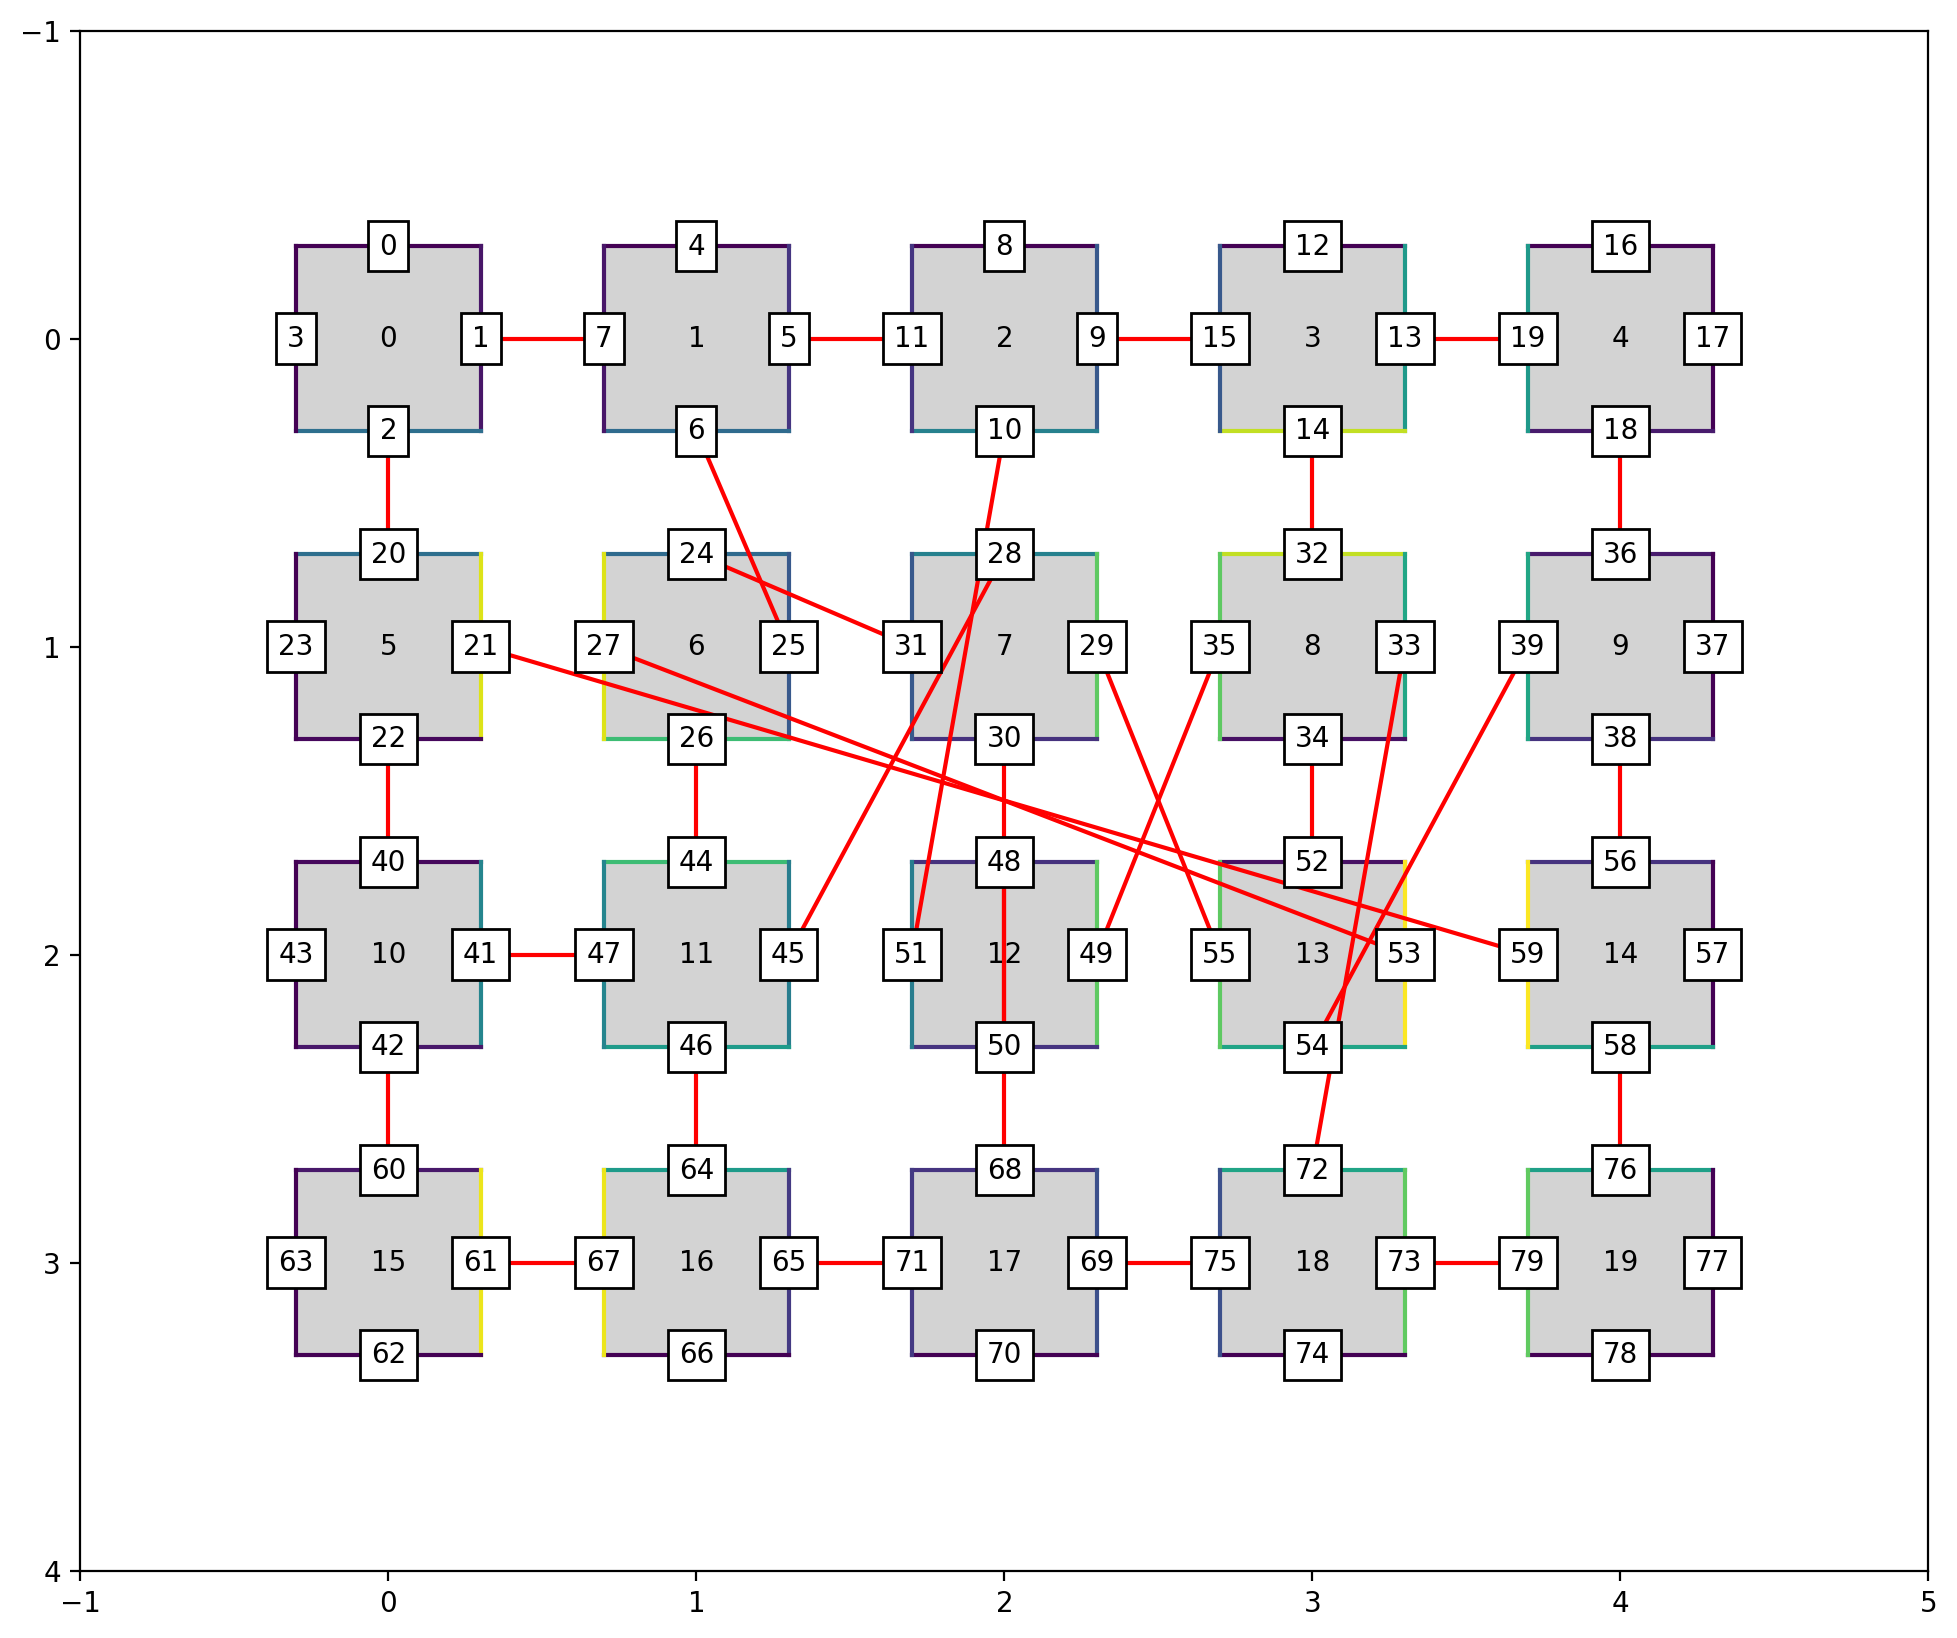

In [636]:
fig, ax = plt.subplots(dpi=200, figsize=(15, 10))
draw_jigsaw(ax)

# for src, tgt in edges:
#     ax.plot([vertex_pos[src][0], vertex_pos[tgt][0]], [vertex_pos[src][1], vertex_pos[tgt][1]], c="gray")

for src, tgt in matching:
    ax.plot([vertex_pos[src][0], vertex_pos[tgt][0]], [vertex_pos[src][1], vertex_pos[tgt][1]], c="red")

In [637]:
matching_lookup = {src: tgt for src, tgt in matching}
matching_lookup.update({tgt: src for src, tgt in matching})

In [638]:
stack = [matching[0][0]]
visited_tiles = set()
vertex_orientations = {
    stack[0]: ORIENTATIONS[stack[0] % 4], # Select specific start orientation for imore intuitive viualization. But any other orientation would also work.
} 
visited_edges = []
error_src, error_tgt = None, None

while len(stack) > 0:
    current_v = stack[0]

    tile_id = vt_lookup[current_v]
    tile_vertices = tv_lookup[tile_id]

    visited_tiles.add(tile_id)
    current_orientation = vertex_orientations[current_v]

    rotation = rotate_array(
        ORIENTATIONS,
        ORIENTATIONS.index(current_orientation) - np.where(tile_vertices == current_v)[0][0],
    )

    for src, rot in zip(tile_vertices, rotation):
        vertex_orientations[src] = rot

        tgt = matching_lookup.get(src, None)

        if tgt is not None: # Why it can be None???
            next_tile = vt_lookup[tgt]

            if next_tile in visited_tiles:
                if COUNTER_ORIENTATIONS[rot] != vertex_orientations[tgt]:
                    error_src = src
                    error_tgt = tgt
                    raise Exception(f"Orientation missmatch: Vertex {tgt} has ambiguous orientation: {COUNTER_ORIENTATIONS[rot]}, {vertex_orientations[tgt]} (Current vertex: {src})")
            else:
                stack.append(tgt)
                visited_edges.append(stuple((src, tgt)))
                vertex_orientations[tgt] = COUNTER_ORIENTATIONS[rot]
        if src in stack:
            stack.remove(src)


    # del stack[0]

Exception: Orientation missmatch: Vertex 29 has ambiguous orientation: E, N (Current vertex: 55)

In [ ]:
tile_graph = nx.Graph()
for src, tgt in visited_edges:
    if stuple((src, tgt)) != stuple((error_src, error_tgt)):
        tile_graph.add_edge(vt_lookup[src], vt_lookup[tgt])

In [639]:
tile_graph.edges

EdgeView([(6, 7), (6, 1), (6, 11), (6, 13), (7, 11), (7, 12), (1, 2), (1, 0), (11, 16), (11, 10), (13, 8), (13, 9)])

In [640]:
# Step 2. Find shortest path between conflicting vertices in tile graph

In [641]:
shortest_path_tile = nx.shortest_path(tile_graph, vt_lookup[error_src], vt_lookup[error_tgt])

In [642]:
shortest_path_tile

[13, 6, 7]

In [643]:
# Step 3: Convert shortest path from tile graph to cycle in vertex graph

In [644]:
shortest_path = [(error_tgt, error_src)]

for i in range(len(shortest_path_tile) - 1):
    found_ = False
    for candidate in tv_lookup[shortest_path_tile[i]]:
        if vt_lookup.get(matching_lookup.get(candidate, None), None) == shortest_path_tile[i+1]:
            shortest_path.append((candidate, matching_lookup[candidate]))
            found_ = True
            break
    assert found_

In [645]:
# shortest_path = [stuple(el) for el in shortest_path]
shortest_path

[(29, 55), (53, 27), (24, 31)]

In [646]:
# Add constraint
# model.orientation_constraints = pyomo.ConstraintList()
lhs = 0
for e in shortest_path:
    lhs += model.x[edges.index(stuple(e))]
model.orientation_constraints.add(lhs <= len(shortest_path) - 1)

In [647]:
solution = opt.solve(model)

    solver failure.


In [659]:
solution = [bool(model.x[i].value) for i in range(len(edges))]
matching = np.array(edges)[solution]

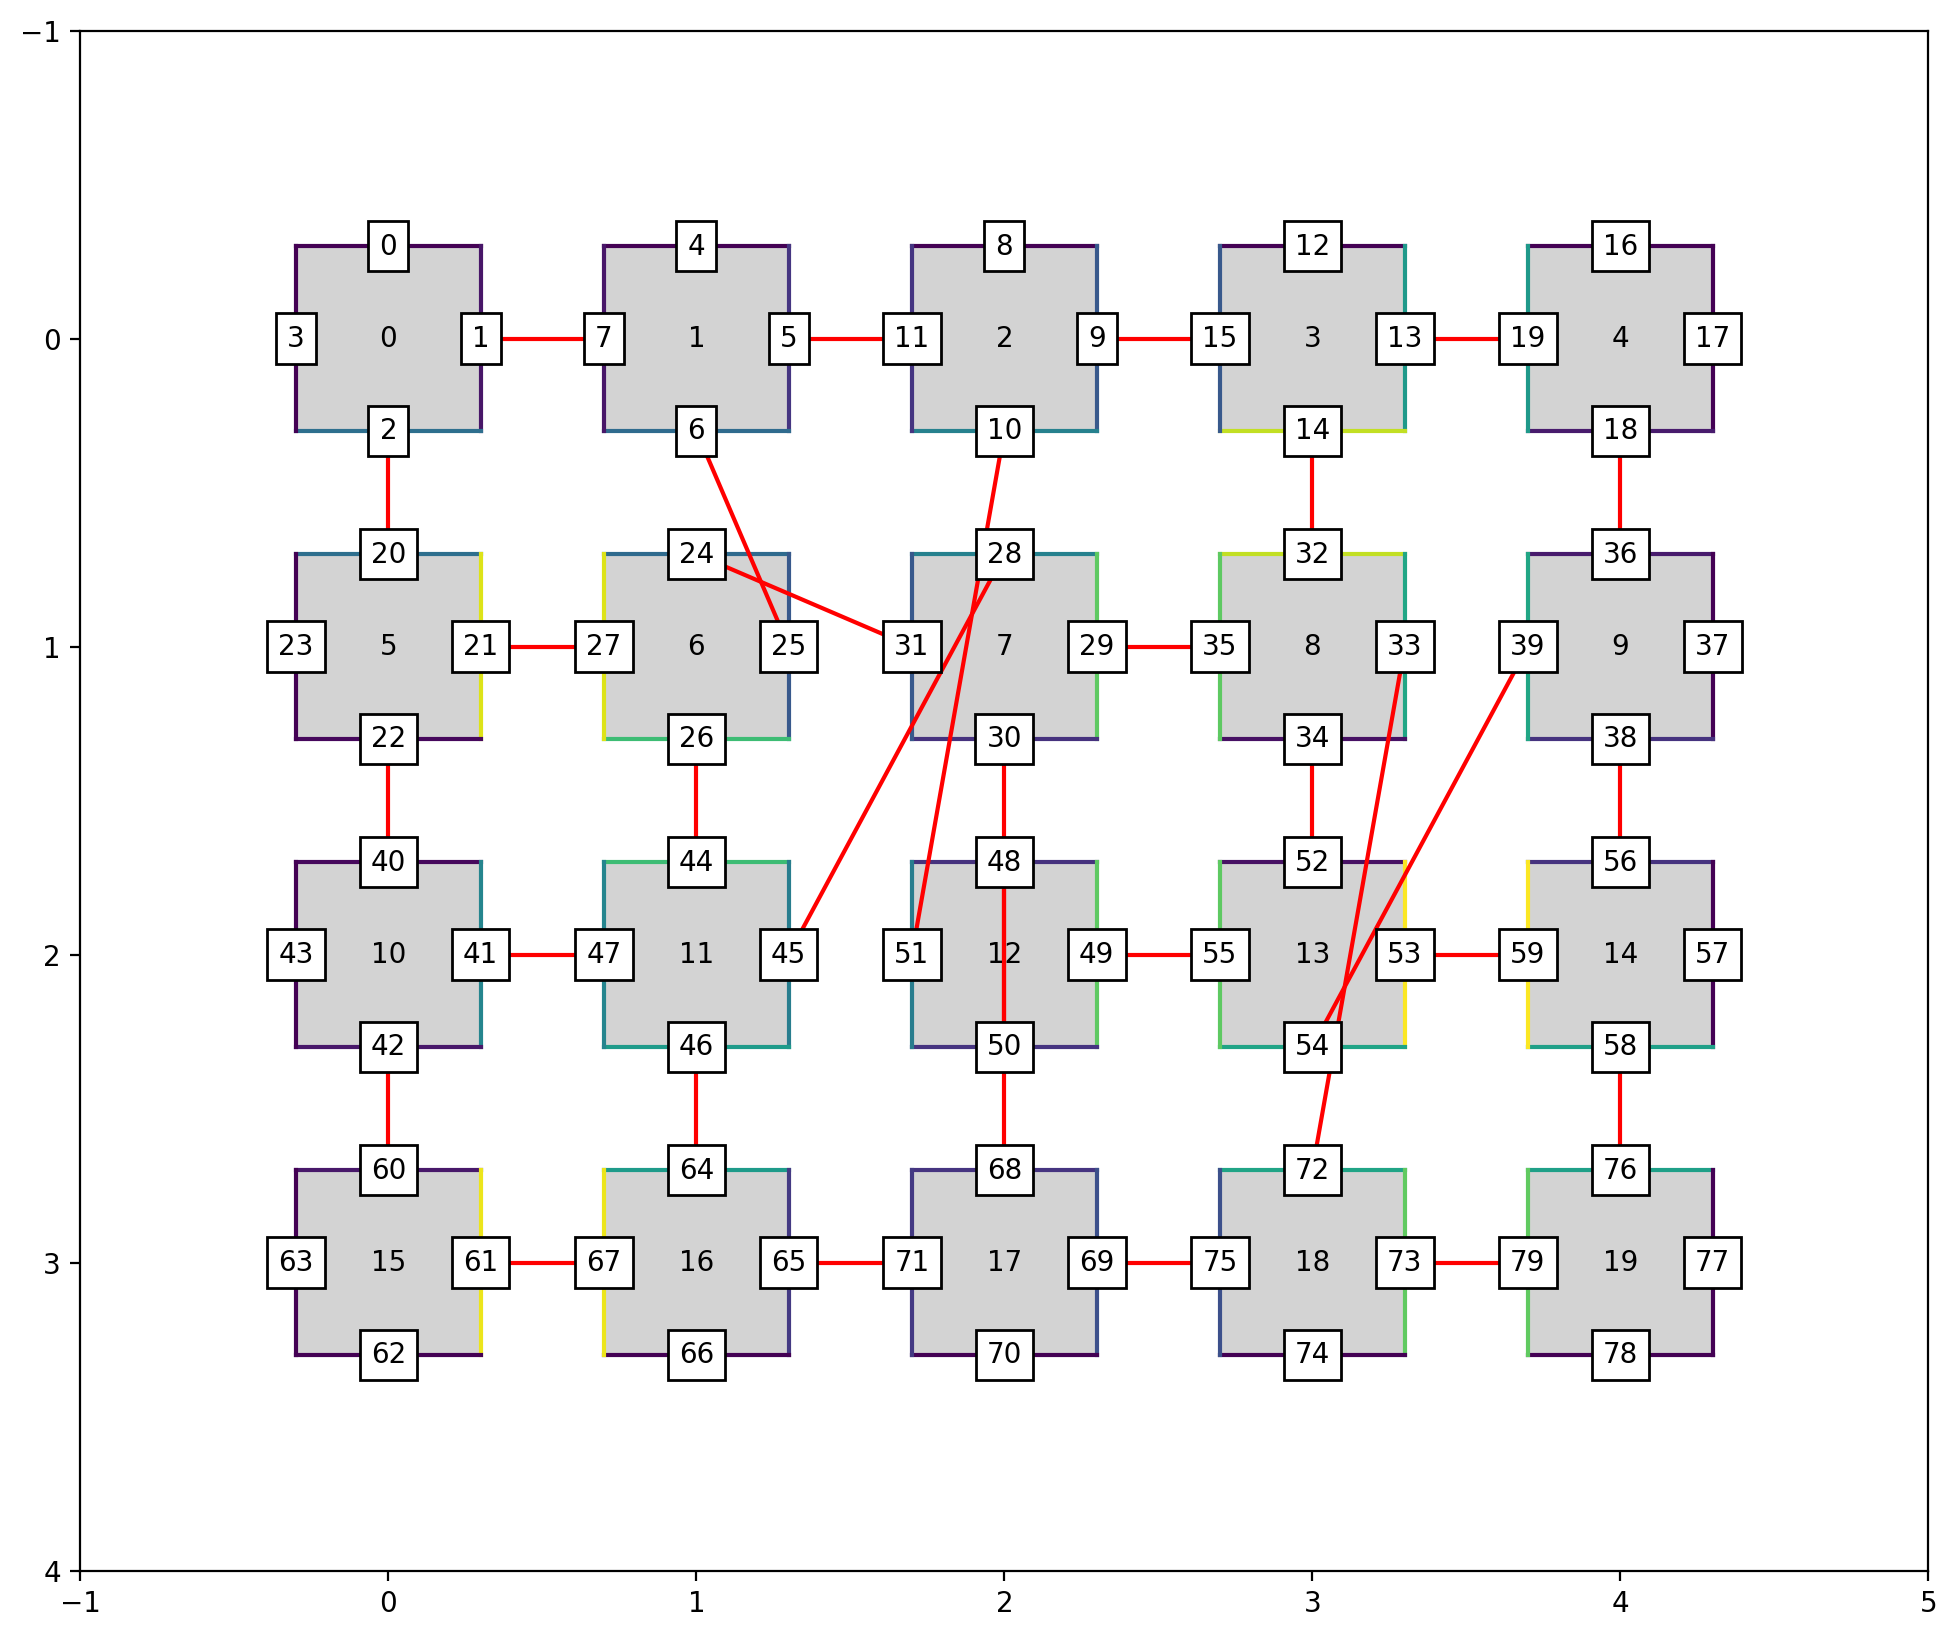

In [660]:
fig, ax = plt.subplots(dpi=200, figsize=(15, 10))
draw_jigsaw(ax)

# for src, tgt in edges:
#     ax.plot([vertex_pos[src][0], vertex_pos[tgt][0]], [vertex_pos[src][1], vertex_pos[tgt][1]], c="gray")

for src, tgt in matching:
    ax.plot([vertex_pos[src][0], vertex_pos[tgt][0]], [vertex_pos[src][1], vertex_pos[tgt][1]], c="red")

In [661]:
matching_lookup = {src: tgt for src, tgt in matching}
matching_lookup.update({tgt: src for src, tgt in matching})

In [662]:
stack = [matching[0][0]]
visited_tiles = set()
vertex_orientations = {
    stack[0]: ORIENTATIONS[stack[0] % 4], # Select specific start orientation for imore intuitive viualization. But any other orientation would also work.
} 
visited_edges = []
error_src, error_tgt = None, None

while len(stack) > 0:
    current_v = stack[0]

    tile_id = vt_lookup[current_v]
    tile_vertices = tv_lookup[tile_id]

    visited_tiles.add(tile_id)
    current_orientation = vertex_orientations[current_v]

    rotation = rotate_array(
        ORIENTATIONS,
        ORIENTATIONS.index(current_orientation) - np.where(tile_vertices == current_v)[0][0],
    )

    for src, rot in zip(tile_vertices, rotation):
        vertex_orientations[src] = rot

        tgt = matching_lookup.get(src, None)

        if tgt is not None: # Why it can be None???
            next_tile = vt_lookup[tgt]

            if next_tile in visited_tiles:
                if COUNTER_ORIENTATIONS[rot] != vertex_orientations[tgt]:
                    error_src = src
                    error_tgt = tgt
                    raise Exception(f"Orientation missmatch: Vertex {tgt} has ambiguous orientation: {COUNTER_ORIENTATIONS[rot]}, {vertex_orientations[tgt]} (Current vertex: {src})")
            else:
                stack.append(tgt)
                visited_edges.append(stuple((src, tgt)))
                vertex_orientations[tgt] = COUNTER_ORIENTATIONS[rot]
        if src in stack:
            stack.remove(src)


    # del stack[0]

Exception: Orientation missmatch: Vertex 49 has ambiguous orientation: E, W (Current vertex: 55)

In [663]:
tile_graph = nx.Graph()
for src, tgt in visited_edges:
    if stuple((src, tgt)) != stuple((error_src, error_tgt)):
        tile_graph.add_edge(vt_lookup[src], vt_lookup[tgt])

In [664]:
tile_graph.edges

EdgeView([(7, 11), (7, 8), (7, 12), (7, 6), (11, 6), (11, 16), (11, 10), (8, 3), (8, 18), (8, 13), (12, 17), (12, 2), (6, 1), (6, 5), (16, 17), (16, 15), (10, 5), (10, 15), (3, 4), (3, 2), (18, 19), (18, 17), (13, 14), (13, 9)])

In [665]:
# Step 2. Find shortest path between conflicting vertices in tile graph

In [666]:
shortest_path_tile = nx.shortest_path(tile_graph, vt_lookup[error_src], vt_lookup[error_tgt])

In [667]:
shortest_path_tile

[13, 8, 7, 12]

In [668]:
# Step 3: Convert shortest path from tile graph to cycle in vertex graph

In [669]:
shortest_path

[(49, 55)]

In [670]:
shortest_path = [(error_tgt, error_src)]

for i in range(len(shortest_path_tile) - 1):
    found_ = False
    for candidate in tv_lookup[shortest_path_tile[i]]:
        if vt_lookup.get(matching_lookup.get(candidate, None), None) == shortest_path_tile[i+1]:
            shortest_path.append((candidate, matching_lookup[candidate]))
            found_ = True
            break
    assert found_

In [671]:
# shortest_path = [stuple(el) for el in shortest_path]
shortest_path

[(49, 55), (52, 34), (35, 29), (30, 50)]

In [672]:
# Add constraint
# model.orientation_constraints = pyomo.ConstraintList()
lhs = 0
for e in shortest_path:
    lhs += model.x[edges.index(stuple(e))]
model.orientation_constraints.add(lhs <= len(shortest_path) - 1)

In [673]:
solution = opt.solve(model)

    solver failure.


In [674]:
solution = [bool(model.x[i].value) for i in range(len(edges))]
matching = np.array(edges)[solution]

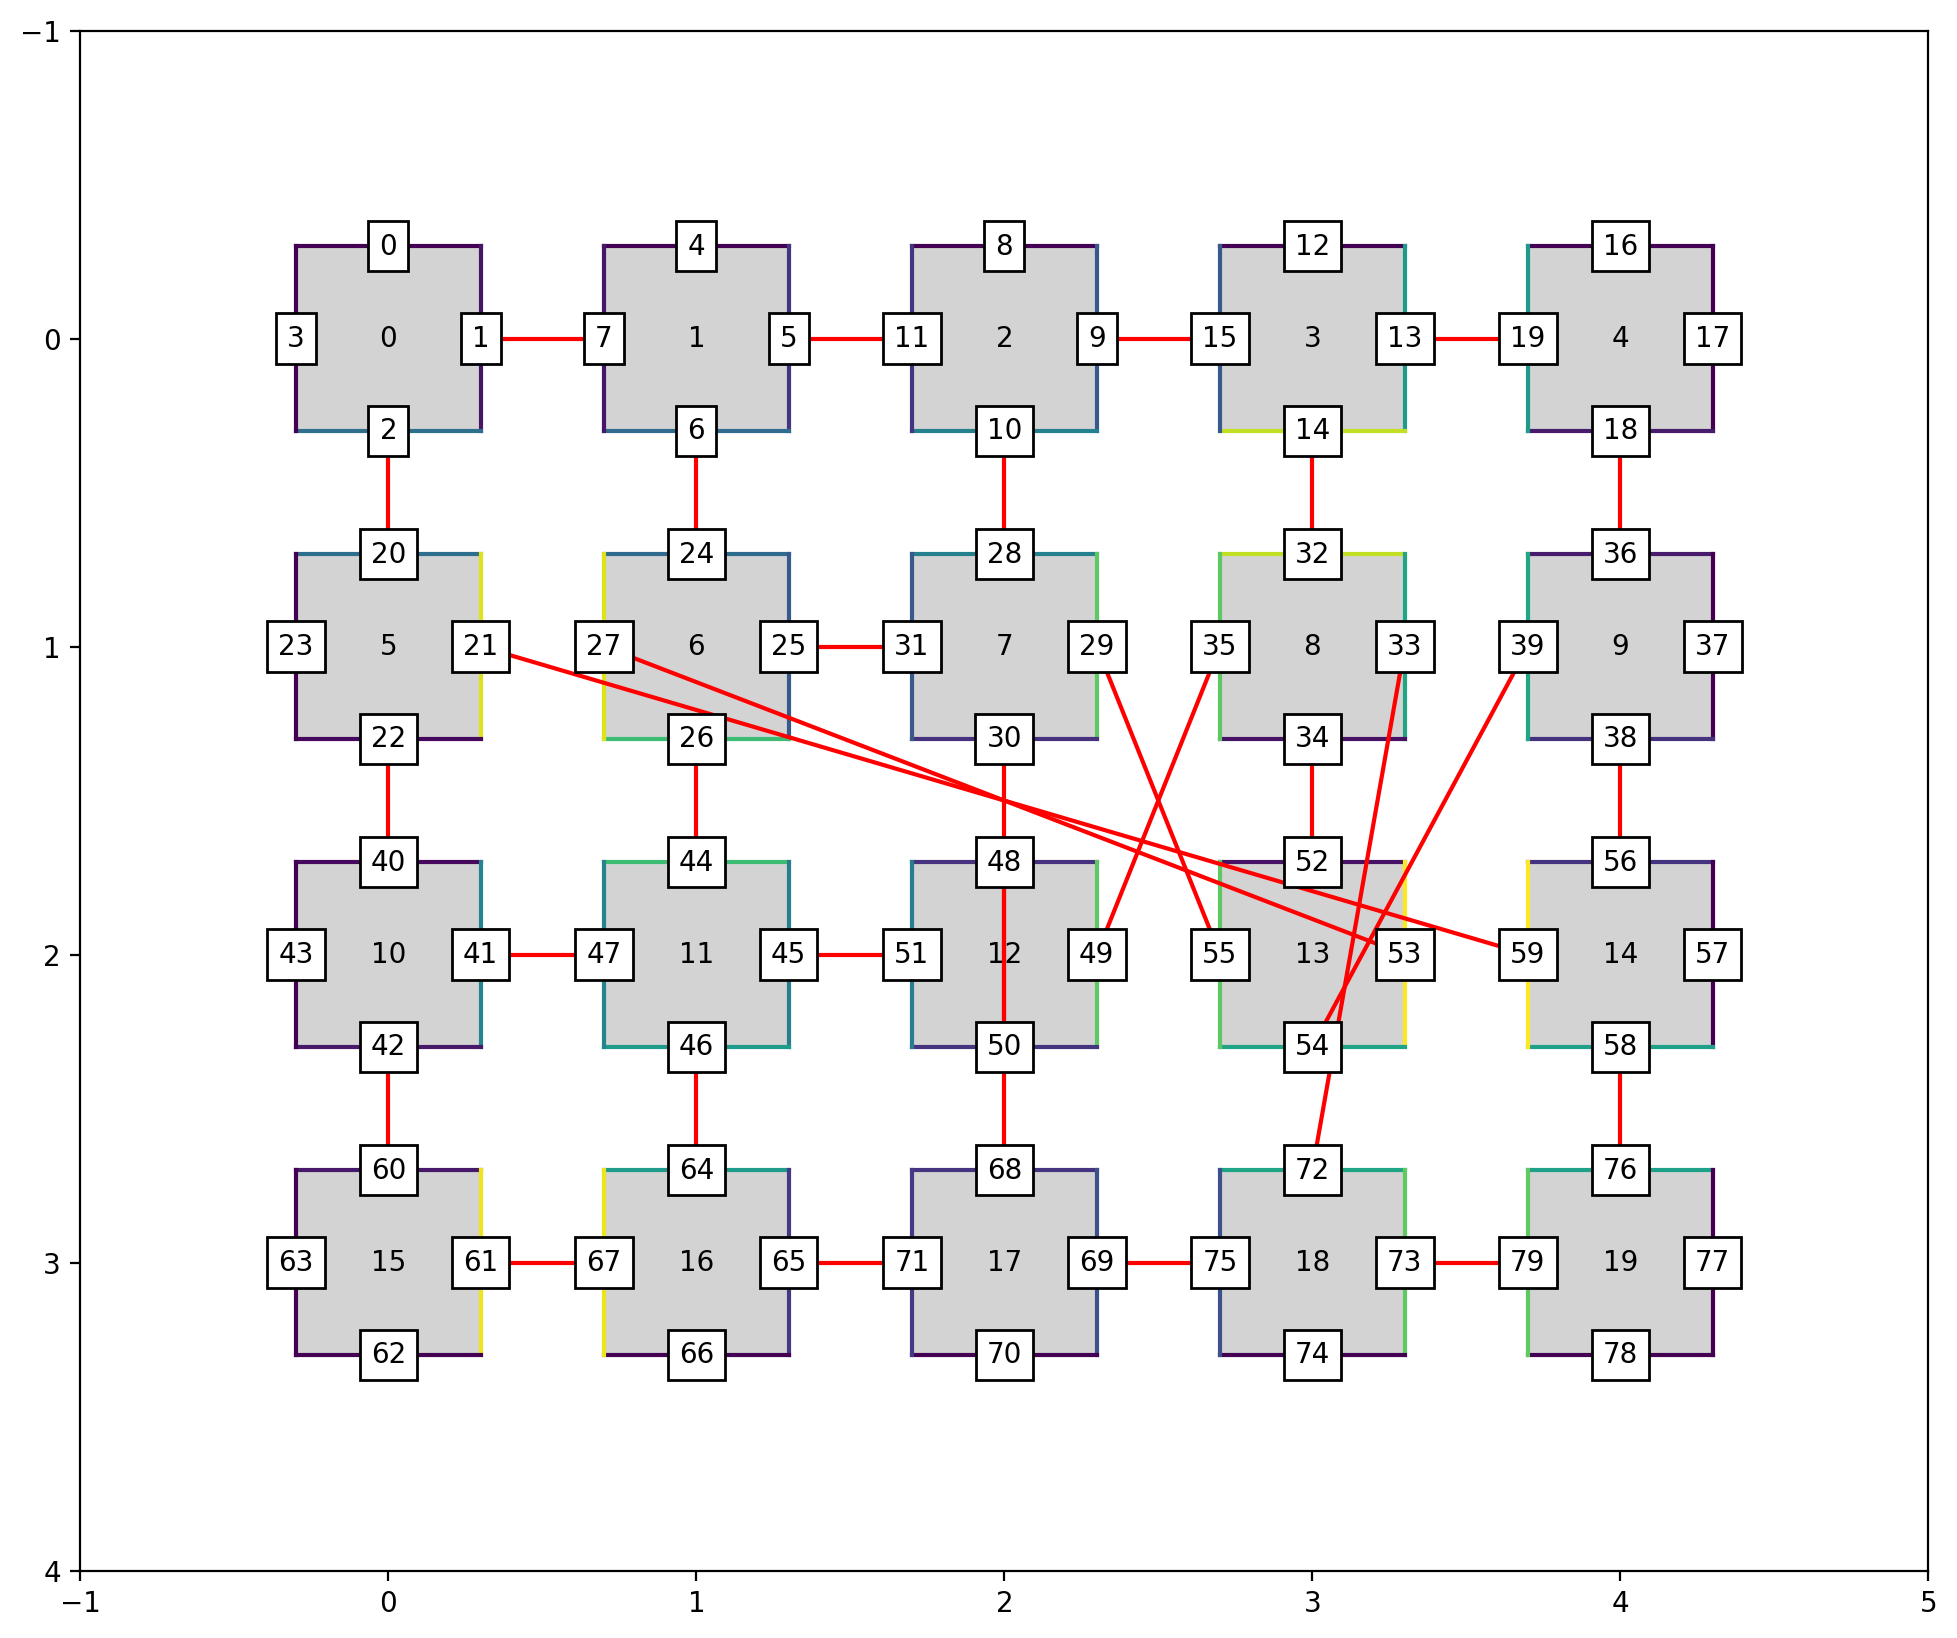

In [675]:
fig, ax = plt.subplots(dpi=200, figsize=(15, 10))
draw_jigsaw(ax)

# for src, tgt in edges:
#     ax.plot([vertex_pos[src][0], vertex_pos[tgt][0]], [vertex_pos[src][1], vertex_pos[tgt][1]], c="gray")

for src, tgt in matching:
    ax.plot([vertex_pos[src][0], vertex_pos[tgt][0]], [vertex_pos[src][1], vertex_pos[tgt][1]], c="red")

In [676]:
matching_lookup = {src: tgt for src, tgt in matching}
matching_lookup.update({tgt: src for src, tgt in matching})

In [677]:
stack = [matching[0][0]]
visited_tiles = set()
vertex_orientations = {
    stack[0]: ORIENTATIONS[stack[0] % 4], # Select specific start orientation for imore intuitive viualization. But any other orientation would also work.
} 
visited_edges = []
error_src, error_tgt = None, None

while len(stack) > 0:
    current_v = stack[0]

    tile_id = vt_lookup[current_v]
    tile_vertices = tv_lookup[tile_id]

    visited_tiles.add(tile_id)
    current_orientation = vertex_orientations[current_v]

    rotation = rotate_array(
        ORIENTATIONS,
        ORIENTATIONS.index(current_orientation) - np.where(tile_vertices == current_v)[0][0],
    )

    for src, rot in zip(tile_vertices, rotation):
        vertex_orientations[src] = rot

        tgt = matching_lookup.get(src, None)

        if tgt is not None: # Why it can be None???
            next_tile = vt_lookup[tgt]

            if next_tile in visited_tiles:
                if COUNTER_ORIENTATIONS[rot] != vertex_orientations[tgt]:
                    error_src = src
                    error_tgt = tgt
                    raise Exception(f"Orientation missmatch: Vertex {tgt} has ambiguous orientation: {COUNTER_ORIENTATIONS[rot]}, {vertex_orientations[tgt]} (Current vertex: {src})")
            else:
                stack.append(tgt)
                visited_edges.append(stuple((src, tgt)))
                vertex_orientations[tgt] = COUNTER_ORIENTATIONS[rot]
        if src in stack:
            stack.remove(src)


    # del stack[0]

Exception: Orientation missmatch: Vertex 45 has ambiguous orientation: W, E (Current vertex: 51)

In [678]:
tile_graph = nx.Graph()
for src, tgt in visited_edges:
    if stuple((src, tgt)) != stuple((error_src, error_tgt)):
        tile_graph.add_edge(vt_lookup[src], vt_lookup[tgt])

In [679]:
tile_graph.edges

EdgeView([(1, 6), (1, 2), (1, 0), (6, 7), (6, 11), (6, 13), (7, 2), (7, 13), (7, 12), (11, 16), (11, 10), (13, 8), (13, 9), (2, 3), (0, 5), (12, 17), (12, 8)])

In [680]:
# Step 2. Find shortest path between conflicting vertices in tile graph

In [681]:
shortest_path_tile = nx.shortest_path(tile_graph, vt_lookup[error_src], vt_lookup[error_tgt])

In [682]:
shortest_path_tile

[12, 7, 6, 11]

In [683]:
# Step 3: Convert shortest path from tile graph to cycle in vertex graph

In [684]:
shortest_path = [(error_tgt, error_src)]

for i in range(len(shortest_path_tile) - 1):
    found_ = False
    for candidate in tv_lookup[shortest_path_tile[i]]:
        if vt_lookup.get(matching_lookup.get(candidate, None), None) == shortest_path_tile[i+1]:
            shortest_path.append((candidate, matching_lookup[candidate]))
            found_ = True
            break
    assert found_

In [685]:
# shortest_path = [stuple(el) for el in shortest_path]
shortest_path

[(45, 51), (50, 30), (31, 25), (26, 44)]

In [686]:
# Add constraint
# model.orientation_constraints = pyomo.ConstraintList()
lhs = 0
for e in shortest_path:
    lhs += model.x[edges.index(stuple(e))]
model.orientation_constraints.add(lhs <= len(shortest_path) - 1)

In [687]:
solution = opt.solve(model)

    solver failure.


In [688]:
solution = [bool(model.x[i].value) for i in range(len(edges))]
matching = np.array(edges)[solution]

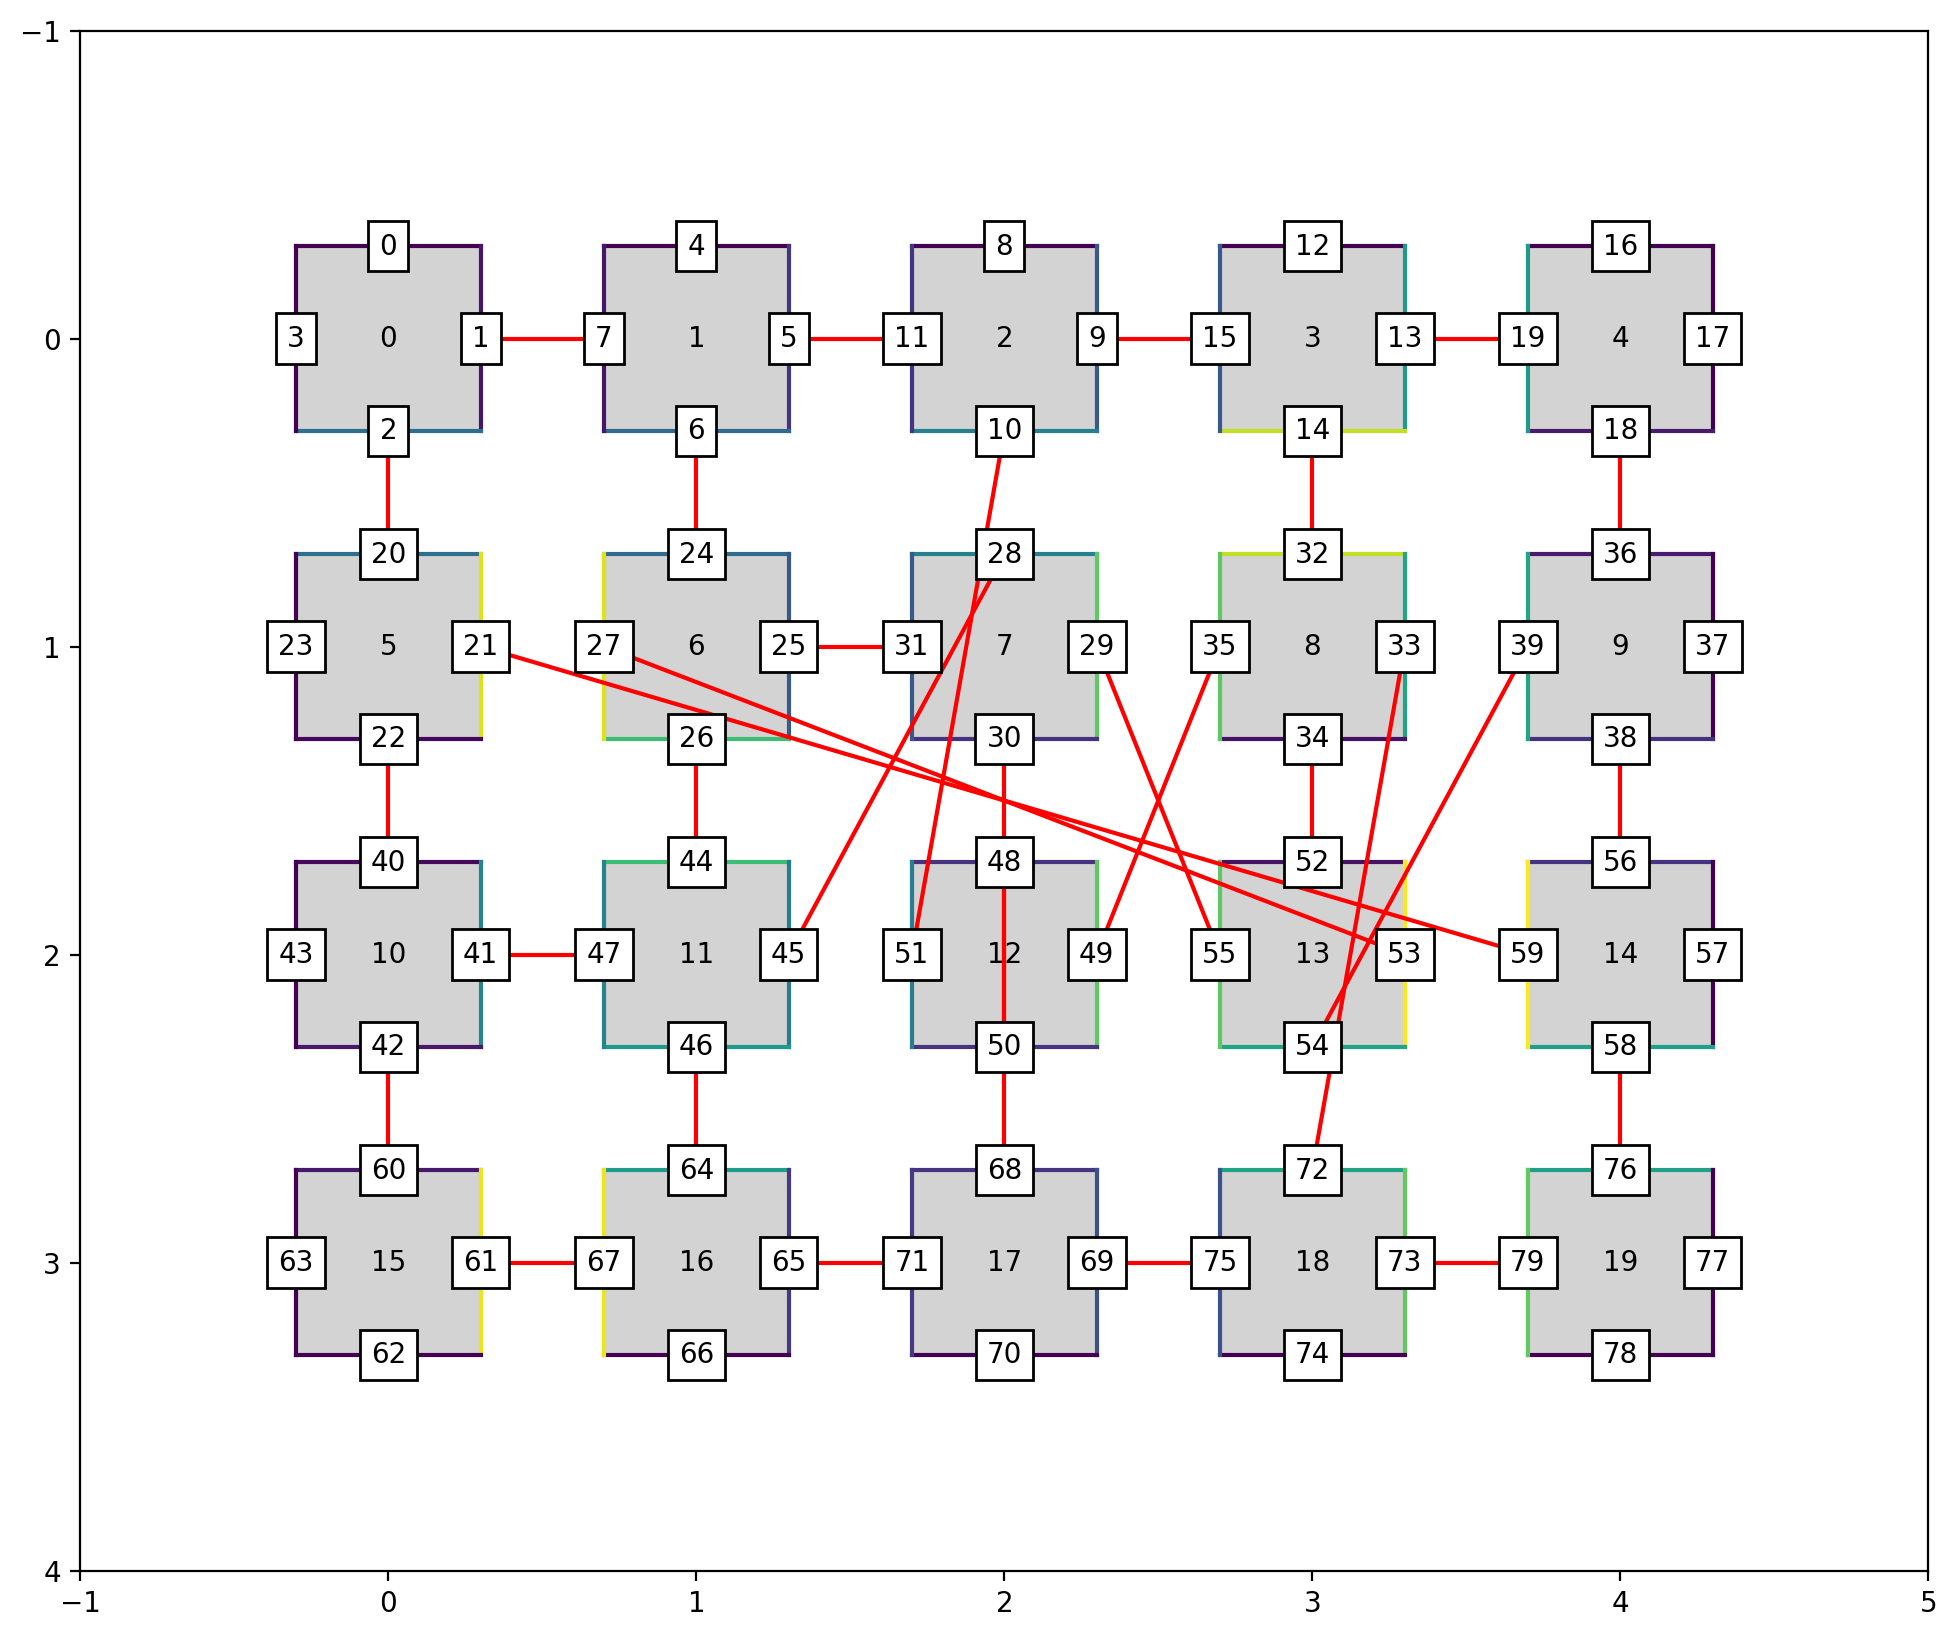

In [689]:
fig, ax = plt.subplots(dpi=200, figsize=(15, 10))
draw_jigsaw(ax)

# for src, tgt in edges:
#     ax.plot([vertex_pos[src][0], vertex_pos[tgt][0]], [vertex_pos[src][1], vertex_pos[tgt][1]], c="gray")

for src, tgt in matching:
    ax.plot([vertex_pos[src][0], vertex_pos[tgt][0]], [vertex_pos[src][1], vertex_pos[tgt][1]], c="red")

In [690]:
matching_lookup = {src: tgt for src, tgt in matching}
matching_lookup.update({tgt: src for src, tgt in matching})

In [691]:
stack = [matching[0][0]]
visited_tiles = set()
vertex_orientations = {
    stack[0]: ORIENTATIONS[stack[0] % 4], # Select specific start orientation for imore intuitive viualization. But any other orientation would also work.
} 
visited_edges = []
error_src, error_tgt = None, None

while len(stack) > 0:
    current_v = stack[0]

    tile_id = vt_lookup[current_v]
    tile_vertices = tv_lookup[tile_id]

    visited_tiles.add(tile_id)
    current_orientation = vertex_orientations[current_v]

    rotation = rotate_array(
        ORIENTATIONS,
        ORIENTATIONS.index(current_orientation) - np.where(tile_vertices == current_v)[0][0],
    )

    for src, rot in zip(tile_vertices, rotation):
        vertex_orientations[src] = rot

        tgt = matching_lookup.get(src, None)

        if tgt is not None: # Why it can be None???
            next_tile = vt_lookup[tgt]

            if next_tile in visited_tiles:
                if COUNTER_ORIENTATIONS[rot] != vertex_orientations[tgt]:
                    error_src = src
                    error_tgt = tgt
                    raise Exception(f"Orientation missmatch: Vertex {tgt} has ambiguous orientation: {COUNTER_ORIENTATIONS[rot]}, {vertex_orientations[tgt]} (Current vertex: {src})")
            else:
                stack.append(tgt)
                visited_edges.append(stuple((src, tgt)))
                vertex_orientations[tgt] = COUNTER_ORIENTATIONS[rot]
        if src in stack:
            stack.remove(src)


    # del stack[0]

Exception: Orientation missmatch: Vertex 28 has ambiguous orientation: W, N (Current vertex: 45)

In [692]:
tile_graph = nx.Graph()
for src, tgt in visited_edges:
    if stuple((src, tgt)) != stuple((error_src, error_tgt)):
        tile_graph.add_edge(vt_lookup[src], vt_lookup[tgt])

In [693]:
tile_graph.edges

EdgeView([(1, 6), (1, 2), (1, 0), (6, 7), (6, 11), (6, 13), (7, 13), (7, 12)])

In [694]:
# Step 2. Find shortest path between conflicting vertices in tile graph

In [695]:
shortest_path_tile = nx.shortest_path(tile_graph, vt_lookup[error_src], vt_lookup[error_tgt])

In [696]:
shortest_path_tile

[11, 6, 7]

In [697]:
# Step 3: Convert shortest path from tile graph to cycle in vertex graph

In [698]:
shortest_path = [(error_tgt, error_src)]

for i in range(len(shortest_path_tile) - 1):
    found_ = False
    for candidate in tv_lookup[shortest_path_tile[i]]:
        if vt_lookup.get(matching_lookup.get(candidate, None), None) == shortest_path_tile[i+1]:
            shortest_path.append((candidate, matching_lookup[candidate]))
            found_ = True
            break
    assert found_

In [699]:
# shortest_path = [stuple(el) for el in shortest_path]
shortest_path

[(28, 45), (44, 26), (25, 31)]

In [700]:
# Add constraint
# model.orientation_constraints = pyomo.ConstraintList()
lhs = 0
for e in shortest_path:
    lhs += model.x[edges.index(stuple(e))]
model.orientation_constraints.add(lhs <= len(shortest_path) - 1)

In [701]:
solution = opt.solve(model)

    solver failure.


In [702]:
solution = [bool(model.x[i].value) for i in range(len(edges))]
matching = np.array(edges)[solution]

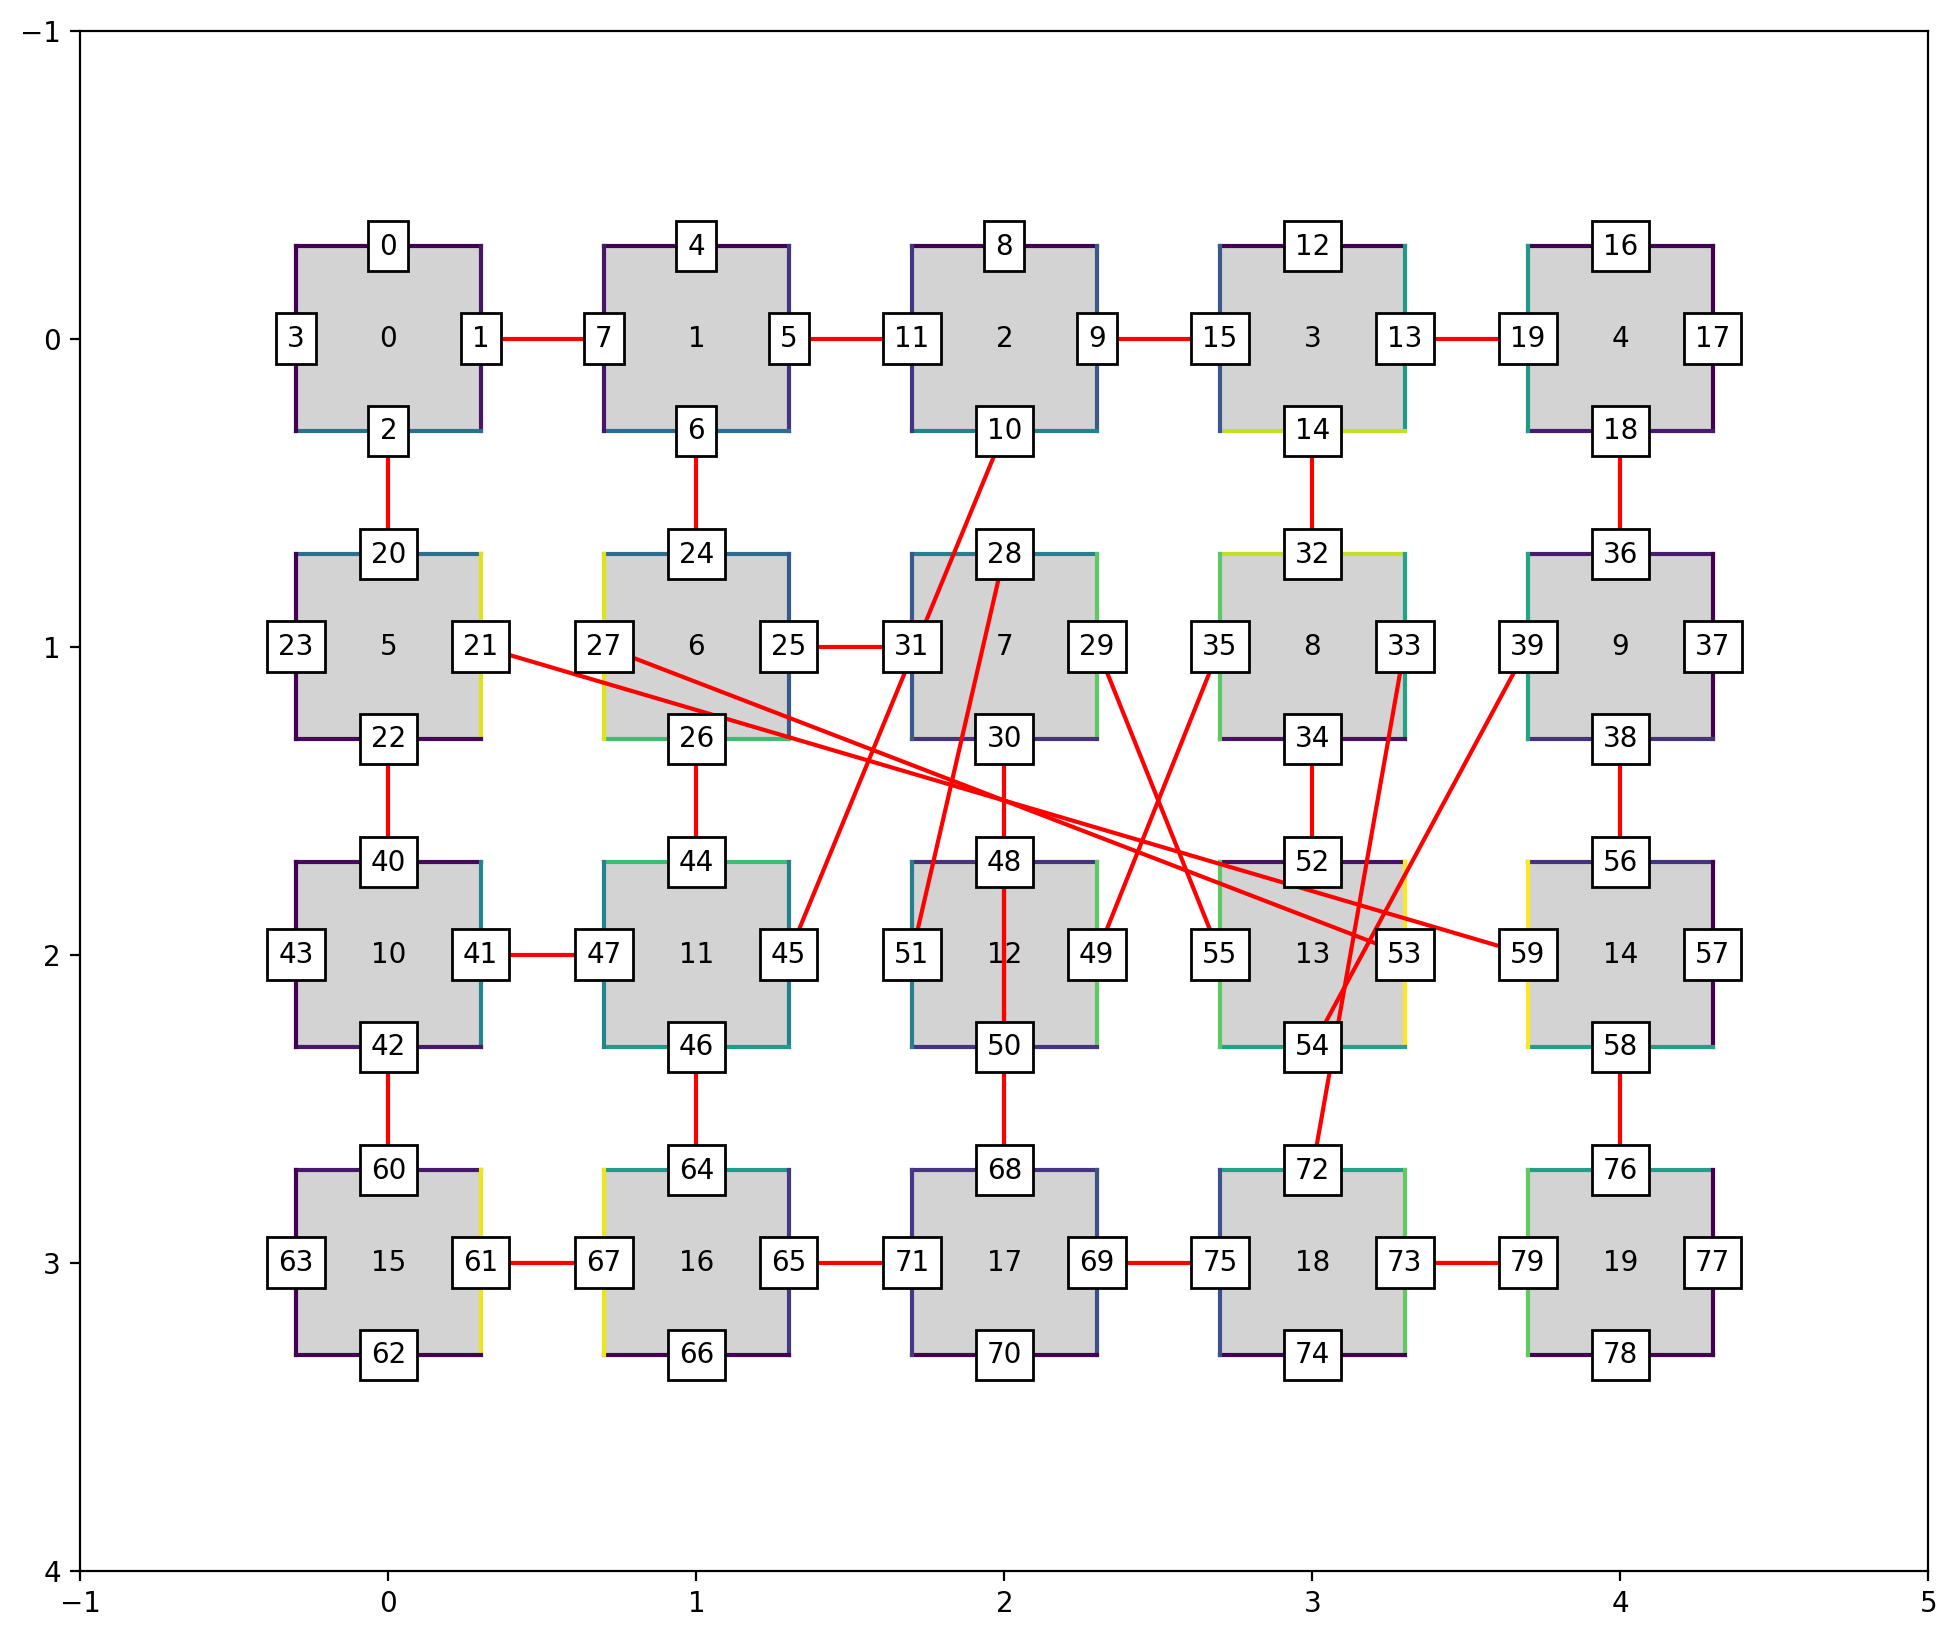

In [703]:
fig, ax = plt.subplots(dpi=200, figsize=(15, 10))
draw_jigsaw(ax)

# for src, tgt in edges:
#     ax.plot([vertex_pos[src][0], vertex_pos[tgt][0]], [vertex_pos[src][1], vertex_pos[tgt][1]], c="gray")

for src, tgt in matching:
    ax.plot([vertex_pos[src][0], vertex_pos[tgt][0]], [vertex_pos[src][1], vertex_pos[tgt][1]], c="red")